# Modelling using value of Reproduction Rate

Modelling with R0 as target variable. R0 represents the average number of people infected by one infectious individual. 

## Import libraries

In [987]:
import pandas as pd, numpy as np, time
import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
import lightgbm as lgb
from xgboost import XGBRegressor
import xgboost
from xgboost import plot_importance
from xgboost import plot_tree
from sklearn import preprocessing
import shap
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from sklearn.model_selection import TimeSeriesSplit
%matplotlib inline

## Authenticate to Google Drive 
(Request access to lucasbotellaroca@gmail.com if not conceded)
Retrieve all files from different folders

In [181]:
# A browser window will open. Login using the appropriate account.
gauth = GoogleAuth()
gauth.LocalWebserverAuth() #

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=267819126046-3da5rmgml4iemor49ermcv23tnaj02t5.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


In [182]:
drive = GoogleDrive(gauth)

In [183]:
drive

## Auxiliary Functions

##### read_csv_file(folder, fileName, nrows)
Returns a dataframe from specific folder and file name from Google Drive, if not found returns empty dataframe.

In [184]:
def read_csv_file(folder, fileName, nrows):
    
    read_file = drive.ListFile({'q': "title contains '" + fileName + ".csv' and '" + folder + "' in parents"}).GetList()
    
    if len(read_file)>0:
        title = read_file[0]['title']
        id = read_file[0]['id']
        each_file = drive.CreateFile({'id': id})
        each_file.GetContentFile(title)
        df = pd.read_csv(title, skiprows=nrows)
    else:
        
        df=pd.DataFrame()
    
    return df

##### highlight_min()
Highlights minimum values for every dataframe column, used to highlight lowest erros in predictions.

In [917]:
def highlight_min(data):
    return data.style.highlight_min(color = 'lightgreen', 
                       axis = 0, subset=['mae', 'mse', 'rmse', 'mape'])

##### aux_plot_real_vs_pred()
Creates a df with test vs predicted values of reprodcution rate and creates a bar plot.

In [186]:
def aux_plot_real_vs_pred(approach, y_real, y_pred):
    plt.style.use('ggplot')
    reg_real_vs_pred = pd.DataFrame({'Actual': y_real, 'Predicted': y_pred})
    reg_real_vs_pred = reg_real_vs_pred.head(30)
    reg_real_vs_pred.plot(kind='bar', color=['darksalmon', 'teal'],figsize=(15,5)).set_title('Predicted vs Actual Approach ' + str(approach+1))
    plt.show()

##### plot_aux()
Plots measured vs predicted values for reproduction rate selected in train and test together with the perfect fit line.

In [187]:
def plot_aux(approach, y_test, y_pred, y_train, y_pred_train, ax):
    ax[approach][0].scatter(y_test, y_pred, color='cornflowerblue', alpha=.6)
    ax[approach][0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=1)
    ax[approach][0].set_title('Test Set Approach ' + str(approach+1))
    ax[approach][0].set_xlabel('Measured')
    ax[approach][0].set_ylabel('Predicted')
    
    ax[approach][1].scatter(y_train, y_pred_train, color='coral', alpha=.8)
    ax[approach][1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=1)
    ax[approach][1].set_xlabel('Measured')
    ax[approach][1].set_ylabel('Predicted')
    ax[approach][1].set_title('Train Set Approach ' + str(approach+1))
    
    
    ax[approach][2].scatter(y_pred_train,y_train-y_pred_train, color='coral', alpha=.8)
    ax[approach][2].scatter(y_pred,y_test-y_pred, color='cornflowerblue', alpha=.6)
    ax[approach][2].plot([0, y_train.max()], [0, 0], 'k--', lw=1)
    ax[approach][2].set_xlabel('Predicted Value')
    ax[approach][2].set_ylabel('Residuals')
    ax[approach][2].set_title('Residuals Plot Approach ' + str(approach+1))

##### plot_aux_2()
Plots measured vs predicted values for reproduction rate selected in train and test together with the perfect fit line. One single approach.

In [188]:
def plot_aux_2(approach, y_test, y_pred, y_train, y_pred_train, ax):
    ax[0].scatter(y_test, y_pred, color='dodgerblue', alpha=.6)
    ax[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=1)
    ax[0].set_title('Test Set Approach ' + str(approach+1))
    ax[0].set_xlabel('Measured')
    ax[0].set_ylabel('Predicted')
    
    ax[1].scatter(y_train, y_pred_train, color='indigo', alpha=.6)
    ax[1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=1)
    ax[1].set_xlabel('Measured')
    ax[1].set_ylabel('Predicted')
    ax[1].set_title('Train Set Approach ' + str(approach+1))
    
    
    ax[2].scatter(y_pred_train,y_train-y_pred_train, color='indigo', alpha=.6)
    ax[2].scatter(y_pred,y_test-y_pred, color='dodgerblue', alpha=.6)
    ax[2].plot([0, y_train.max()], [0, 0], 'k--', lw=1)
    ax[2].set_xlabel('Predicted Value')
    ax[2].set_ylabel('Residuals')
    ax[2].set_title('Residuals Plot Approach ' + str(approach+1))

##### plot_aux_3()
Plots measured vs predicted values for reproduction rate selected in train and test together with the perfect fit line. Available for any model in x,y coordinates of ax axes.

In [426]:
def aux_plot_3(model, x, y, y_test, y_pred, y_train, ax):
    
    ax[x][y].scatter(y_test, y_pred, color='cornflowerblue', alpha=.6)
    ax[x][y].plot([0, 2], [0,2], 'k--', lw=1)
    ax[x][y].set_title(model)
    ax[x][y].set_xlabel('Measured')
    ax[x][y].set_ylabel('Predicted')
    
    ax[x][y].set_xlim([0,2])
    ax[x][y].set_ylim([0,2])

##### get_values_metric()
Returns dataframes ready to plot for comparison three models with three different approaches.

In [189]:
def get_values_metric(metric):
    
    df_scores_xgb_rel=pd.DataFrame()
    df_scores_xgb_rel['Train']=df_scores_xgb_train[metric]
    df_scores_xgb_rel['Test']=df_scores_xgb[metric]
    
    df_scores_lgb_rel=pd.DataFrame()
    df_scores_lgb_rel['Train']=df_scores_lgb_train[metric]
    df_scores_lgb_rel['Test']=df_scores_lgb[metric]
    
    df_scores_gbst_rel=pd.DataFrame()
    df_scores_gbst_rel['Train']=df_scores_train_gbr[metric]
    df_scores_gbst_rel['Test']=df_scores_gbr[metric]
    
    df_scores_knn_rel=pd.DataFrame()
    df_scores_knn_rel['Train']=df_scores_knn_train[metric]
    df_scores_knn_rel['Test']=df_scores_knn[metric]
    
    df_scores_hist_rel=pd.DataFrame()
    df_scores_hist_rel['Train']=df_scores_hist_train[metric]
    df_scores_hist_rel['Test']=df_scores_hist[metric]
    
    df_scores_NuSVR_rel=pd.DataFrame()
    df_scores_NuSVR_rel['Train']=df_scores_NuSVR_train[metric]
    df_scores_NuSVR_rel['Test']=df_scores_NuSVR[metric]
    
    return df_scores_xgb_rel,df_scores_lgb_rel, df_scores_gbst_rel, df_scores_knn_rel, df_scores_hist_rel, df_scores_NuSVR_rel

##### get_metrics_data_frame()
Returns mae, mse, rmse, mape and r2 for passed values.

In [933]:
def get_metrics_data_frame(y_appch1,y_pred_1,y_appch2,y_pred_2, y_appch3, y_pred_3):

    mae_1 = mean_absolute_error(y_appch1, y_pred_1)
    mse_1 = mean_squared_error(y_appch1, y_pred_1)
    rmse_1 = np.sqrt(mean_squared_error(y_appch1, y_pred_1))
    r2_1 = r2_score(y_appch1, y_pred_1)
    mape_1 = np.mean(np.abs((y_appch1 - y_pred_1) / y_appch1)) * 100

    mae_2 = mean_absolute_error(y_appch2, y_pred_2)
    mse_2 = mean_squared_error(y_appch2, y_pred_2)
    rmse_2 = np.sqrt(mean_squared_error(y_appch2, y_pred_2))
    r2_2 = r2_score(y_appch2, y_pred_2)
    mape_2 = np.mean(np.abs((y_appch2 - y_pred_2) / y_appch2)) * 100

    mae_3 = mean_absolute_error(y_appch3, y_pred_3)
    mse_3 = mean_squared_error(y_appch3, y_pred_3)
    rmse_3 = np.sqrt(mean_squared_error(y_appch3, y_pred_3))
    r2_3 = r2_score(y_appch3, y_pred_3)
    mape_3 = np.mean(np.abs((y_appch3 - y_pred_3) / y_appch3)) * 100

    scores = { 'mae' : {'Approach 1': mae_1, 'Approach 2': mae_2, 'Approach 3': mae_3},
               'mse' : {'Approach 1': mse_1, 'Approach 2': mse_2, 'Approach 3': mse_3},
               'rmse' : {'Approach 1': rmse_1, 'Approach 2': rmse_2, 'Approach 3': rmse_3}, 
               'mape' : {'Approach 1':mape_1, 'Approach 2':mape_2, 'Approach 3':mape_3},
               'r2' : {'Approach 1':r2_1, 'Approach 2':r2_2, 'Approach 3':r2_3}}
    
    df_scores=pd.DataFrame(scores)
    
    return df_scores

##### time_test_split_custom()

Custom functions that creates time series split with fixed initial value. Meaning, the model will be trained with at least n first rows, since modelling with first for example 200 rows may result in non relevant results. This function plots model outputs and returns the dataframe with all metrics for all folds.

***Fold n- Train(0, 1000) Test(1000+index, 1000+index+204) where index=n*204**

We are going to be taking steps of 204 rows.

In [1302]:
def time_test_split_custom(model):
    
    scaler = preprocessing.StandardScaler().fit(df_time[df_time.columns[3:-1]])

    X = pd.DataFrame(scaler.transform(df_time[df_time.columns[3:-1]]), columns=df_time.columns[3:-1])

    y=df_time[df_time.columns[-1]]

    aux_df=pd.DataFrame(columns=['mae', 'rmse', 'mse', 'mape', 'r2_test', 'r2_train', 'std_test', 'std_train'])

    iter = 0
    index=0

    while ((1000+index+204)<2224): 

        X_train, X_test = X.iloc[1:1000+index], X.iloc[1000+index:1000+index+204]   
        y_train, y_test = y.iloc[1:1000+index], y.iloc[1000+index:1000+index+204]

        index=index+204
        
        model.fit(X_train, y_train)
        y_pred=model.predict(X_test)
        y_pred_train=model.predict(X_train)

        fig, ax = plt.subplots(1,3,figsize=(15,5))
        plot_aux_2(1,y_test, y_pred, y_train, y_pred_train, ax)

        mae = mean_absolute_error(y_pred, y_test)
        rmse = np.sqrt(mean_squared_error(y_pred, y_test))
        mse = mean_squared_error(y_pred, y_test)
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

        mae = mean_absolute_error(y_pred, y_test)
        rmse = np.sqrt(mean_squared_error(y_pred, y_test))
        mse = mean_squared_error(y_pred, y_test)
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

        r2_train = r2_score(y_pred_train, y_train)
        r2_test = r2_score(y_pred, y_test)
        std_train = np.var(y_train)
        std_test = np.var(y_test)
        aux_df.loc['Fold ' + str(iter)]=[mae, rmse, mse, mape, r2_test, r2_train, std_test, std_train]
        iter = iter+1
        
    return aux_df

## Read file and prepare data 

Retrieve data frame and select useful columns. After various try and error and changes in the approach of the problem there are some variables that were initially conceived to use but were later on depecredated due to non relation with our target variable reproduction rate. The mentioned variables are:
* **Doctors, nurses and beds per 1000**, such variables should affect our proxy variable excess deaths, however it does not fit well in our model since doctors, nurses and beds have no relation in the spread of the virus, it may have a relation with the number of deaths but not with the reproduction rate, therefore they have not been used.
* **Life expectancy, population greater than 65 and median age** they all might have a relation with the number oof excess deaths however they don´t fit in this model as well, since its effect is related with one of the features (our proxy variable for infections which is excesss deaths) but has no relation with our target variable reproduction rate.

We make a couple of decision regarding the data:

* Simply remove rows with missing infectious or accumulated values. Both variables are higly related with our target vairbale, and are crucial in the SIR Model, therefore, we simply remove rows that do not contain information in such variables.
* If vacciantions are null will replace them by zeros.
* We replace values smaller than zero to, since there are no "negative infections", values samller than zeo are related with no infected individuals, thus it cannot be negative.

In [1003]:
#df=pd.read_csv('df_covid_processed_final_reproduction_rate.csv')
df=read_csv_file('1EsuOqiCqQK5HSCI3aPOvOUq2kXsXd5uH','df_covid_processed_final_reproduction_rate',0)

#Selected columns for our analysis
df=df[['Code', 'Date', 'retail_and_recreation',
       'grocery_and_pharmacy', 'residential', 'transit_stations', 'parks',
       'workplaces', 'debt_relief', 'income_support', 'testing_policy',
       'international_travel_controls', 'restrictions_internal_movements',
       'close_public_transport', 'public_information_campaigns',
       'facial_coverings', 'contact_tracing', 
       'stay_home_requirements', 'restriction_gatherings',
       'cancel_public_events', 'workplace_closures', 'school_closures',
       'holiday', 'temp', 'prcp', 'number_of_arrivals', 'urban_population',
      'total_vaccinations_per_100', 'youth_unemployment','infections_value',
      'accumulated', 'reproduction_rate']]

df = df[df['infections_value'].notna()]
df = df[df['accumulated'].notna()]
df['total_vaccinations_per_100'] = df['total_vaccinations_per_100'].fillna(0)
df['infections_value'][df['infections_value'] < 0] = 0

df

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=267819126046-3da5rmgml4iemor49ermcv23tnaj02t5.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


,Code,Date,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces,debt_relief,income_support,...,holiday,temp,prcp,number_of_arrivals,urban_population,total_vaccinations_per_100,youth_unemployment,infections_value,accumulated,reproduction_rate
0,AUS,2020-03-22,0.714429,8.979571,-0.387571,5.448857,-2.857143,8.326571,0.000000,0.0,...,0.0,21.346512,0.142010,8263000.0,85.904,0.000000,11.84,7.28,0.002502,2.170000
1,AUS,2020-03-29,-0.898000,15.163286,0.448857,-1.061286,-4.959143,6.959000,0.000000,1.0,...,0.0,21.176835,0.054789,8263000.0,85.904,0.000000,11.84,12.13,0.003071,2.330000
2,AUS,2020-04-05,-10.591857,22.020286,5.102143,-21.836714,-14.836714,-0.918286,0.285714,1.0,...,0.0,20.702945,0.051898,8263000.0,85.904,0.000000,11.84,11.31,0.003808,2.280000
3,AUS,2020-04-12,-32.163429,-0.020429,13.428429,-48.775571,-28.183714,-22.816286,2.000000,1.0,...,0.0,21.093375,0.073336,8263000.0,85.904,0.000000,11.84,6.36,0.005034,1.457143
4,AUS,2020-04-19,-40.918429,-12.347143,17.612143,-60.204143,-39.326571,-35.265286,2.000000,1.0,...,0.0,18.880697,0.118556,8263000.0,85.904,0.000000,11.84,2.95,0.006178,0.765714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3572,USA,2021-01-31,-24.673429,-12.857143,10.795714,-40.183714,-19.183714,-28.816286,1.000000,2.0,...,1.0,3.141409,0.027324,75608000.0,82.058,4.160000,8.30,28.11,0.217541,0.892857
3573,USA,2021-02-07,-25.836714,-14.142714,10.734429,-41.285714,-21.000143,-28.816143,1.000000,2.0,...,0.0,1.441940,0.060531,75608000.0,82.058,6.405714,8.30,25.01,0.223260,0.848571
3574,USA,2021-02-14,-25.938714,-14.551000,10.714000,-41.714286,-25.775714,-27.938714,1.000000,2.0,...,0.0,0.586187,0.055322,75608000.0,82.058,9.125714,8.30,15.60,0.228214,0.825714
3575,USA,2021-02-21,-24.489857,-12.326571,10.142857,-40.591714,-23.285714,-27.489714,1.000000,2.0,...,0.0,-1.192456,0.032941,75608000.0,82.058,12.074286,8.30,12.85,0.232621,0.780000


Text(0.5, 1.0, 'reproduction_rate')

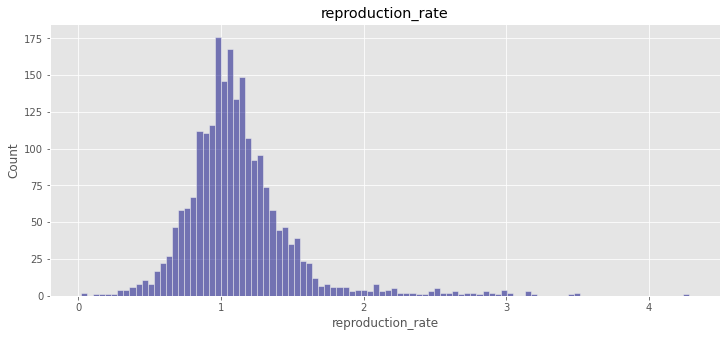

In [1004]:
#Removing -inf and infinite
df=df[~df.isin([np.inf, -np.inf]).any(1)]
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='reproduction_rate', data=df, kde=False, bins=100, ax=axes, color='navy', alpha=.5);
axes.set_title('reproduction_rate')

## Feature Engineering

Based on the data exploration section we have conducted that lots of variables have a high correlation, which is something expected. 
* Mobility is of course affected by the measures taken, and the other way around. Also, restrictions and measures do have a high correlation between each other, restrictions are usually applied together and with simillar strictness. 

Based on the article shown (https://towardsdatascience.com/multi-collinearity-in-regression-fe7a2c1467ea)
there are three main approaches to asses the refered problem.

**1.** Drop variables, select meaningful features.

**2.** Transforming variables.

**3.** PCA: Principal Component Analysis

For our specific case, we will take three approaches.

* **Approach 1**: Raw data no grouping of variables or PCA Analysis - We first want to know how the model performs withiut any changes in our dataset.

* **Approach 2**: Grouping variables, decreasing dimensionality and correlation - We will perform feature engineering grouping variables with simillar correlations on our target variable base on the data exploration section.

* **Approach 3: PCA**: Since variables have a high correlation we will group variables taking use of Principal Component Analysis.
 
However it is stated by some staticians that grouping variables when correlated does not necesseraly mean an improvement in the predcitions.

**"The fact that some or all predictor variables are correlated among themselves does not, in general, inhibit our ability to obtain a good fit nor does it tend to affect inferences about mean responses or predictions of new observations.  —Applied Linear Statistical Models, p289, 4th Edition."**

Even though when grouping variables we might not have better predictions this might be useful in order to interpret the model afterwards, since one feature may absorb the effect of another. 
Hence, we will explore three approaches and observe which one best fits our prupose which as stated is not only getting precise predictions but also, a good interpretabily and explanation of the model itself.

In the presented problem we will work with some models that work with nul values and others that do not. In order to have appropiate datasets for all approaches with all the models evaluated we will create **2 sets of datasets for each approach**, one with raw data **df_appch_x**, no null treatment **"df_appch_x_clean"**, and another with null values treatment and standar scaling applied. Approach 3 only contains one dataset since in order to perform PCA we need the dataset to be "clean".

### Approach 1: Raw data no grouping of variables or PCA Analysis
Train models with raw data, no previous transformation or grouping done

In [1005]:
df_appch1=df.copy()

In [1006]:
df_appch1_clean=df.copy()
df_appch1_clean['prcp'] = df_appch1_clean['prcp'].fillna(df_appch1_clean['prcp'].mean())
df_appch1_clean['temp'] = df_appch1_clean['temp'].fillna(df_appch1_clean['temp'].mean())
df_appch1_clean['parks'] = df_appch1_clean['parks'].fillna(df_appch1_clean['prcp'].mean())
df_appch1_clean['number_of_arrivals'] = df_appch1_clean['number_of_arrivals'].fillna(df_appch1_clean['number_of_arrivals'].mean())
df_appch1_clean['urban_population'] = df_appch1_clean['urban_population'].fillna(df_appch1_clean['urban_population'].mean())
df_appch1_clean['total_vaccinations_per_100'] = df_appch1_clean['total_vaccinations_per_100'].fillna(0)
df_appch1_clean['youth_unemployment']= df_appch1_clean['youth_unemployment'].fillna(df_appch1_clean['youth_unemployment'].mean())
df_appch1_clean = df_appch1_clean[df_appch1_clean['infections_value'].notna()]
df_appch1_clean = df_appch1_clean[df_appch1_clean['retail_and_recreation'].notna()]
df_appch1_clean = df_appch1_clean[df_appch1_clean['grocery_and_pharmacy'].notna()]
df_appch1_clean['accumulated']= df_appch1_clean['accumulated'].fillna(df_appch1_clean['accumulated'].mean())

### Approach 2: Grouping variables, decreasing dimensionality and correlation
Since variables seem to have high multicollinearity will group variables with similar corellation

Grouping of variables based on previous knowledge adquired in the data exploration section.

* Variables grouped as **mobility_index** are variables that have a positive relation in the spread of the virus. Those variables are "retail_and_recreation", "transit_stations", "grocery_and_pharmacy", "workplaces". They have been ponderated to an approximation of more or less effect on the response variable.

* Variables grouped as **awareness_measures** are variables that represent the conciency and awareness given from governments to the population, most meaningful one is "facial_coverings".

* Variables grouped as **economic_measures** are measures that support debt and income, which prevents workers from going to work and thus decreasing mobility and activity.

* Variables grouped as **health_measures** are measures that support tracing and testing of cases.

* Variables grouped as **mobility_measures** are measures that limit mobility and interactions between individuals of different households and cities. 

* Variables grouped as **closure_measures** are measures that limit usual work and school life together with events.

There are some other variables such as: 'residential', 'holiday', 'temp', 'prcp','number_of_arrivals', 'urban_population','total_vaccinations_per_100', 'youth_unemployment','infections_value', 'accumulated' are not modified nor grouped since they appear to be independent from each other and its effect on the response variable.

In [1007]:
df_appch2=df.copy()

In [1008]:
df_appch2['mobility_index']=(df_appch2['retail_and_recreation']*0.4+df_appch2['transit_stations']*0.4
                           +df_appch2['grocery_and_pharmacy']*0.1+df_appch2['workplaces']*0.1)

df_appch2['awareness_measures'] = df_appch2['public_information_campaigns']*0.2+df_appch2['facial_coverings']*0.8

df_appch2['economic_measures']=df_appch2['debt_relief']*0.5+df_appch2['income_support']*0.5
df_appch2['health_measures']=df_appch2['contact_tracing']*0.5+df_appch2['testing_policy']*0.5
df_appch2['mobility_measures']=0.3*df_appch2['stay_home_requirements']\
                                + 0.3*df_appch2['restriction_gatherings']\
                                + 0.2*df_appch2['restrictions_internal_movements']\
                                + 0.1*df_appch2['international_travel_controls']\
                                + 0.1*df_appch2['close_public_transport']\
                    

df_appch2['closure_measures'] = 0.2*df_appch2['cancel_public_events']\
                                + 0.4*df_appch2['workplace_closures']\
                                + 0.4*df_appch2['school_closures']

df_appch2=df_appch2[['Code', 'Date','mobility_index', 'residential',
                     'awareness_measures', 'health_measures',
                     'mobility_measures', 'economic_measures',
                     'closure_measures',
                     'holiday', 'temp', 'prcp', 
                     'number_of_arrivals', 'urban_population',
                     'total_vaccinations_per_100', 'youth_unemployment',
                     'infections_value', 'accumulated', 'reproduction_rate']]

In [1009]:
df_appch2.head()

,Code,Date,mobility_index,residential,awareness_measures,health_measures,mobility_measures,economic_measures,closure_measures,holiday,temp,prcp,number_of_arrivals,urban_population,total_vaccinations_per_100,youth_unemployment,infections_value,accumulated,reproduction_rate
0,AUS,2020-03-22,4.195929,-0.387571,0.4,1.5,0.300000,0.000000,0.000000,0.0,21.346512,0.142010,8263000.0,85.904,0.0,11.84,7.28,0.002502,2.170000
1,AUS,2020-03-29,1.428514,0.448857,0.4,1.5,0.557143,0.500000,0.114286,0.0,21.176835,0.054789,8263000.0,85.904,0.0,11.84,12.13,0.003071,2.330000
2,AUS,2020-04-05,-10.861229,5.102143,0.4,1.5,1.557143,0.642857,1.085714,0.0,20.702945,0.051898,8263000.0,85.904,0.0,11.84,11.31,0.003808,2.280000
3,AUS,2020-04-12,-34.659271,13.428429,0.4,1.5,2.171429,1.500000,2.400000,0.0,21.093375,0.073336,8263000.0,85.904,0.0,11.84,6.36,0.005034,1.457143
4,AUS,2020-04-19,-45.210271,17.612143,0.4,1.5,2.600000,1.500000,2.400000,0.0,18.880697,0.118556,8263000.0,85.904,0.0,11.84,2.95,0.006178,0.765714


As seen multicollinearity is still veasible with some measures, mobility index and residential are opposed which makes sense, and measures tend to have high correlation with mobility and residential trends

<AxesSubplot:>

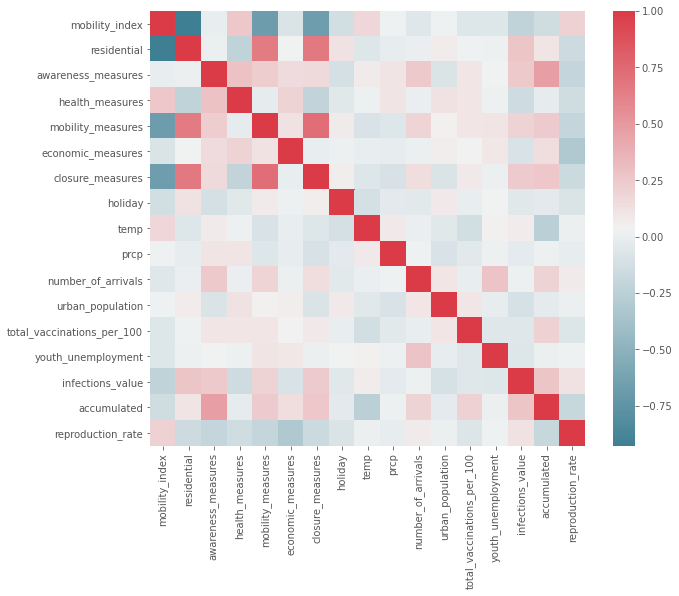

In [1010]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df_appch2.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [1011]:
df_appch2_clean=df_appch2.copy()
df_appch2_clean['prcp'] = df_appch2_clean['prcp'].fillna(df_appch2_clean['prcp'].mean())
df_appch2_clean['temp'] = df_appch2_clean['temp'].fillna(df_appch2_clean['temp'].mean())
df_appch2_clean['number_of_arrivals'] = df_appch2_clean['number_of_arrivals'].fillna(df_appch2_clean['number_of_arrivals'].mean())
df_appch2_clean['urban_population'] = df_appch2_clean['urban_population'].fillna(df_appch2_clean['urban_population'].mean())
df_appch2_clean['total_vaccinations_per_100'] = df_appch2_clean['total_vaccinations_per_100'].fillna(0)
df_appch2_clean['youth_unemployment']= df_appch2_clean['youth_unemployment'].fillna(df_appch2_clean['youth_unemployment'].mean())
df_appch2_clean = df_appch2_clean[df_appch2_clean['infections_value'].notna()]
df_appch2_clean['accumulated']= df_appch2_clean['accumulated'].fillna(df_appch2_clean['accumulated'].mean())

In [1012]:
df_appch2_clean.columns

Index(['Code', 'Date', 'mobility_index', 'residential', 'awareness_measures',
       'health_measures', 'mobility_measures', 'economic_measures',
       'closure_measures', 'holiday', 'temp', 'prcp', 'number_of_arrivals',
       'urban_population', 'total_vaccinations_per_100', 'youth_unemployment',
       'infections_value', 'accumulated', 'reproduction_rate'],
      dtype='object')

### Approach 3: PCA
Since variables have a high correlation we will group variables taking use of Principal Component Analysis

In [1013]:
df_appch3=df.copy()
df_appch3['total_vaccinations_per_100'] = df_appch3['total_vaccinations_per_100'].fillna(0)
df_appch3['accumulated'] = df_appch3['accumulated'].fillna(0)
df_appch3['urban_population'] = df_appch3['urban_population'].fillna(df_appch3['urban_population'].mean())
df_appch3['parks'] = df_appch3['parks'].fillna(df_appch3['parks'].mean())
df_appch3['temp'] = df_appch3['temp'].fillna(df_appch3['temp'].mean())
df_appch3['prcp'] = df_appch3['prcp'].fillna(df_appch3['prcp'].mean())
df_appch3 = df_appch3[df_appch3['retail_and_recreation'].notna()]
df_appch3 = df_appch3[df_appch3['grocery_and_pharmacy'].notna()]
df_appch3['youth_unemployment']= df_appch3['youth_unemployment'].fillna(df_appch3['youth_unemployment'].mean())
df_appch3['number_of_arrivals']=df_appch3['number_of_arrivals'].fillna(df_appch3['number_of_arrivals'].mean())
df_appch3 = df_appch3[df_appch3['infections_value'].notna()]

In [1014]:
df_appch3.columns

Index(['Code', 'Date', 'retail_and_recreation', 'grocery_and_pharmacy',
       'residential', 'transit_stations', 'parks', 'workplaces', 'debt_relief',
       'income_support', 'testing_policy', 'international_travel_controls',
       'restrictions_internal_movements', 'close_public_transport',
       'public_information_campaigns', 'facial_coverings', 'contact_tracing',
       'stay_home_requirements', 'restriction_gatherings',
       'cancel_public_events', 'workplace_closures', 'school_closures',
       'holiday', 'temp', 'prcp', 'number_of_arrivals', 'urban_population',
       'total_vaccinations_per_100', 'youth_unemployment', 'infections_value',
       'accumulated', 'reproduction_rate'],
      dtype='object')

In [1015]:
features=['retail_and_recreation', 'grocery_and_pharmacy',
       'residential', 'transit_stations', 'parks', 'workplaces', 'debt_relief',
       'income_support', 'testing_policy', 'international_travel_controls',
       'restrictions_internal_movements', 'close_public_transport',
       'public_information_campaigns', 'facial_coverings', 'contact_tracing',
       'stay_home_requirements', 'restriction_gatherings',
       'cancel_public_events', 'workplace_closures', 'school_closures',
       'holiday', 'temp', 'prcp', 'total_vaccinations_per_100',
       'infections_value', 'accumulated', 'reproduction_rate']

# Separating out the features
x = df_appch3.reindex(columns = features).values
# Separating out the target
y = df_appch3.reindex(columns = ['reproduction_rate']).values
# Standardizing the features
x = StandardScaler().fit_transform(x)

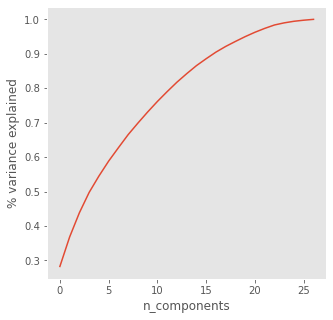

In [1016]:
pca = PCA(n_components = x.shape[1])
pca_data = pca.fit_transform(x)

percent_var_explained = pca.explained_variance_/(np.sum(pca.explained_variance_))
cumm_var_explained = np.cumsum(percent_var_explained)

plt.rcParams["figure.figsize"] = (5,5)
plt.plot(cumm_var_explained)
plt.grid()
plt.xlabel("n_components")
plt.ylabel("% variance explained")
plt.show()

In [1017]:
pca = PCA(n_components = 15)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents)
#Include Date and R0 for later filtering
principalDf['Date']=df_appch3['Date']
principalDf['reproduction_rate']=df_appch3['reproduction_rate']
df_appch3=principalDf

## Modelling and Evaluation

Once we have our three datasets defined we will start with the modelling and evaluation phase.

* The evaluation has not been done randomly since entries in the dataset may have very simillar behaviours and we should expect some false "good-fits", as it has been eperienced. Therefore we will base our evalaution for every model in a **time series split**. Time series are trained with first n entries in time and they are later evaluated with n post entries after date defined.

* Since our evaluation is complex and contains three approaches, together with six different models, we will evaluate what would correspond to an split in time of **2020 year for train** and **2021 for test**. Once we have some intuition of what the best models are based on this configuration, we will test the best models observed in this section using iterative time series split. For this in detail analysis we will use approach 2 sinceit has been recorded and evaluated to be the model getting best results and explainability of its features based on further analysis taken advanatge of SHAP values.

* As mentioned we will create two sets of data for each of the three approachs mentioned,one raw, and another "clean" with null treatement and standard scaling applied. 

* We will aknowledge the differences between **r2 scores** in train and test at then end of the presented notebook, giving an explanation on why it is happening an how it affects our evaluation of the presented models.

In [1018]:
date=pd.Timestamp(2021, 1, 10)

#### Approach 1: Raw data no grouping of variables or PCA Analysis Split

In [1019]:
X_1=df_appch1[(pd.to_datetime(df_appch1['Date']) <= date)]
X_2=df_appch1[(pd.to_datetime(df_appch1['Date']) > date)]
X_train_appch1=X_1[X_1.columns[2:-1]]
X_test_appch1=X_2[X_2.columns[2:-1]]
y_train_appch1=X_1['reproduction_rate']
y_test_appch1=X_2['reproduction_rate']

In [1020]:
X_1_clean=df_appch1_clean[(pd.to_datetime(df_appch1_clean['Date']) <= date)]
X_2_clean=df_appch1_clean[(pd.to_datetime(df_appch1_clean['Date']) > date)]
scaler = preprocessing.StandardScaler().fit(df_appch1_clean[df_appch1_clean.columns[2:-1]])

X_train_appch1_clean = scaler.transform(X_1_clean[X_1_clean.columns[2:-1]])
X_test_appch1_clean = scaler.transform(X_2_clean[X_2_clean.columns[2:-1]])

y_train_appch1_clean=X_1_clean['reproduction_rate']
y_test_appch1_clean=X_2_clean['reproduction_rate']

####  Approach 2: Grouping variables, decreasing dimensionality and correlation Split

In [1021]:
X_1=df_appch2[(pd.to_datetime(df_appch2['Date']) <= date)]
X_2=df_appch2[(pd.to_datetime(df_appch2['Date']) > date)]
X_train_appch2=X_1[X_1.columns[2:-1]]
X_test_appch2=X_2[X_2.columns[2:-1]]
y_train_appch2=X_1['reproduction_rate']
y_test_appch2=X_2['reproduction_rate']

In [1022]:
X_1_clean=df_appch2_clean[(pd.to_datetime(df_appch2_clean['Date']) <= date)]
X_2_clean=df_appch2_clean[(pd.to_datetime(df_appch2_clean['Date']) > date)]
scaler_appch2 = preprocessing.StandardScaler().fit(df_appch2_clean[df_appch2_clean.columns[2:-1]])

X_train_appch2_clean = scaler_appch2.transform(X_1_clean[X_1_clean.columns[2:-1]])
X_test_appch2_clean = scaler_appch2.transform(X_2_clean[X_2_clean.columns[2:-1]])

y_train_appch2_clean=X_1_clean['reproduction_rate']
y_test_appch2_clean=X_2_clean['reproduction_rate']

#### Approach 3: PCA  Split

In [1023]:
X_1=df_appch3[(pd.to_datetime(df_appch3['Date']) <= date)]
X_2=df_appch3[(pd.to_datetime(df_appch3['Date']) > date)]
X_train_appch3=X_1[X_1.columns[0:-2]]
X_test_appch3=X_2[X_2.columns[0:-2]]
y_train_appch3=X_1['reproduction_rate']
y_test_appch3=X_2['reproduction_rate']

In [1024]:
X_train_appch3_clean=X_train_appch3
X_test_appch3_clean=X_test_appch3
y_train_appch3_clean=y_train_appch3
y_test_appch3_clean=y_test_appch3

#### Dataframe for later evaluation of approach 2

After some evaluation of the following models it has been stated and evaluated that the best approach is approach 2 and is the one that provides better explainability for afterwards analysis. Taken this into account, we will store all metrics for every different model in order to evaluate best model and later in detail analysis using time series split. 

In [1025]:
df_eval_approach_2=pd.DataFrame(columns=['mae','mse','mape','rmse', 'r2'])

## XGBoost Regressor 

### Modelling
Parameter selection has been done over try and error in order to avoid under-fitting or over-fitting.

In [1201]:
# A parameter grid for XGBoost
fit_params1={'max_depth' : [4,6,8], 'colsample_bytree':[0.5]}
fit_params2={'max_depth' : [5,6,7], 'colsample_bytree':[0.5]}
fit_params3={'max_depth' : [8,9,10], 'colsample_bytree':[0.5]}

# Initialize XGB and GridSearch
xgb = XGBRegressor() 

grid1_xgb = GridSearchCV(xgb, fit_params1, verbose=0, n_jobs=-1)
grid2_xgb = GridSearchCV(xgb, fit_params2, verbose=0, n_jobs=-1)
grid3_xgb = GridSearchCV(xgb, fit_params3, verbose=0, n_jobs=-1)

In [1202]:
%time

eval_set1 = [(X_train_appch1, y_train_appch1), (X_test_appch1, y_test_appch1)]
eval_set2 = [(X_train_appch2, y_train_appch2), (X_test_appch2, y_test_appch2)]
eval_set3 = [(X_train_appch3, y_train_appch3), (X_test_appch3, y_test_appch3)]

grid1_xgb.fit(X_train_appch1, y_train_appch1, eval_set=eval_set1, early_stopping_rounds=5, verbose=False)
grid2_xgb.fit(X_train_appch2, y_train_appch2, eval_set=eval_set2, early_stopping_rounds=5, verbose=False)
grid3_xgb.fit(X_train_appch3, y_train_appch3, eval_set=eval_set3, early_stopping_rounds=5, verbose=False)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
      

In [1204]:
y_pred_1_xgb=grid1_xgb.best_estimator_.predict(X_test_appch1)
y_pred_train_1_xgb=grid1_xgb.best_estimator_.predict(X_train_appch1)
y_pred_2_xgb=grid2_xgb.best_estimator_.predict(X_test_appch2)
y_pred_train_2_xgb=grid2_xgb.best_estimator_.predict(X_train_appch2)
y_pred_3_xgb=grid3_xgb.best_estimator_.predict(X_test_appch3)
y_pred_train_3_xgb=grid3_xgb.best_estimator_.predict(X_train_appch3)

### XGB Evaluation

#### Test Set

In [1205]:
df_scores_xgb=get_metrics_data_frame(y_test_appch1,y_pred_1_xgb, y_test_appch2, y_pred_2_xgb,y_test_appch3, y_pred_3_xgb)
df_eval_approach_2.loc['XGBoost Regressor'] = df_scores_xgb.loc['Approach 2']
highlight_min(df_scores_xgb)

,mae,mse,rmse,mape,r2
Approach 1,0.150281,0.036037,0.189834,15.386554,-0.220432
Approach 2,0.148949,0.034279,0.185147,14.709373,-0.160905
Approach 3,0.148398,0.036314,0.190563,15.047361,-0.368269


#### Train Set

In [1206]:
df_scores_xgb_train=get_metrics_data_frame(y_train_appch1,y_pred_train_1_xgb, y_train_appch2, y_pred_train_2_xgb,y_train_appch3, y_pred_train_3_xgb)
highlight_min(df_scores_xgb_train)

,mae,mse,rmse,mape,r2
Approach 1,0.146243,0.041210,0.203002,15.747099,0.760760
Approach 2,0.152394,0.043515,0.208603,16.254807,0.747376
Approach 3,0.231918,0.120704,0.347424,18.037480,0.302901


## Results View

#### Actual vs Predicted

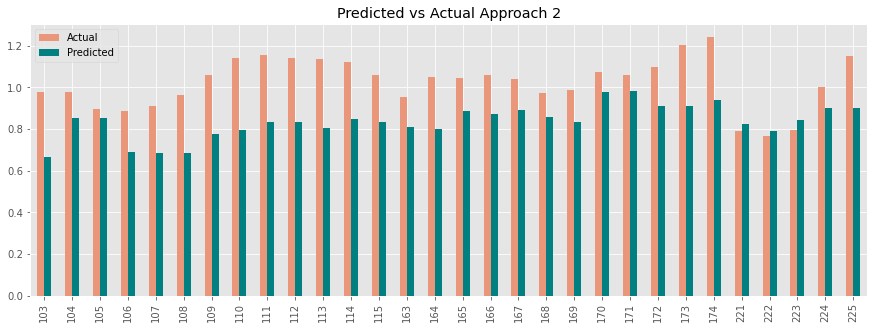

In [1207]:
aux_plot_real_vs_pred(1, y_test_appch2, y_pred_2_xgb)

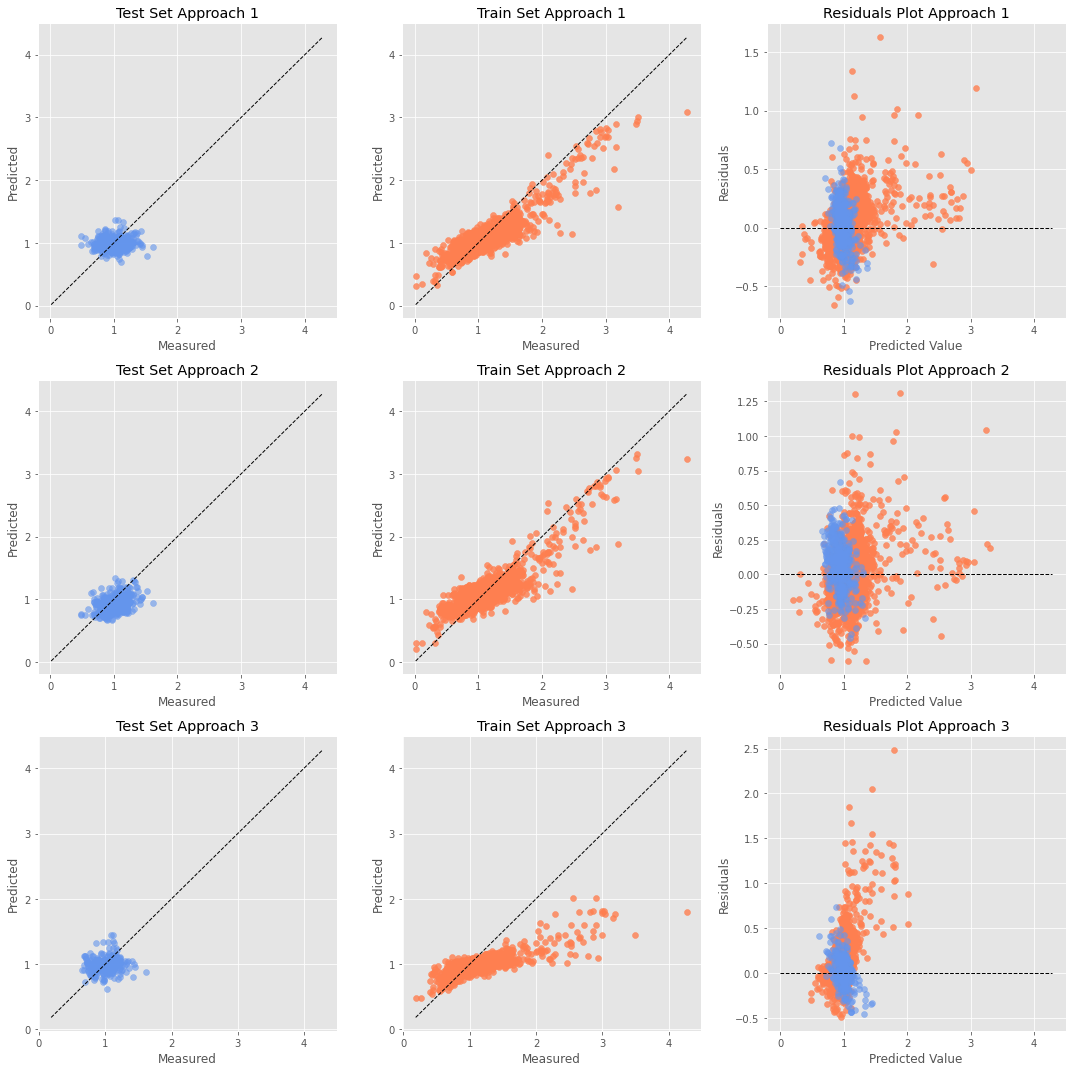

In [1208]:
fig, ax = plt.subplots(3,3,figsize=(15,15))

plot_aux(0, y_test_appch1, y_pred_1_xgb, y_train_appch1, y_pred_train_1_xgb, ax)
plot_aux(1, y_test_appch2, y_pred_2_xgb, y_train_appch2, y_pred_train_2_xgb, ax)
plot_aux(2, y_test_appch3, y_pred_3_xgb, y_train_appch3, y_pred_train_3_xgb, ax)

fig.tight_layout()
plt.show()

* As seen **Approach 2** together with Approach 1 seems to be getting the best result in the test set and is the one getting the best fit to the predicted-measured line.
* Approach 3 seems to be getting bad results. 
* It is also important to note that the **test set has a smaller range of values (0.5, 1.5) than the train set (0, 4.5)** and its concentration and variance is higher.
* There are no signs of overfitting based on the plots shown together with the analysis in the residuals plot.

## Light GBM

### Modelling 
Parameter selection has been done over try and error in order to avoid under-fitting or over-fitting.

In [1110]:
fit_params1={'max_depth' : [7,8,9], 'n_estimators':[18,19,20]}
fit_params2={'max_depth' : [7,8,9], 'n_estimators':[22,23,24]}
fit_params3={'max_depth' : [7,8,9], 'n_estimators':[22,23,24]}


# Initialize LGB and GridSearch
lgbm = lgb.LGBMRegressor()

grid1_lgb = GridSearchCV(lgbm, fit_params1, verbose=0)
grid2_lgb = GridSearchCV(lgbm, fit_params2, verbose=0)
grid3_lgb = GridSearchCV(lgbm, fit_params3, verbose=0)

In [1111]:
%%time

eval_set1 = [(X_train_appch1, y_train_appch1), (X_test_appch1, y_test_appch1)]
eval_set2 = [(X_train_appch2, y_train_appch2), (X_test_appch2, y_test_appch2)]
eval_set3 = [(X_train_appch3, y_train_appch3), (X_test_appch3, y_test_appch3)]

grid1_lgb.fit(X_train_appch1, y_train_appch1, eval_set=eval_set1, verbose=False)
grid2_lgb.fit(X_train_appch2, y_train_appch2, eval_set=eval_set2, verbose=False)
grid3_lgb.fit(X_train_appch3, y_train_appch3, eval_set=eval_set3, verbose=False)

CPU times: user 34.1 s, sys: 1.7 s, total: 35.8 s
Wall time: 11.8 s


GridSearchCV(estimator=LGBMRegressor(),
             param_grid={'max_depth': [7, 8, 9], 'n_estimators': [22, 23, 24]})

In [1112]:
grid1_lgb.best_params_, grid2_lgb.best_params_, grid3_lgb.best_params_

({'max_depth': 8, 'n_estimators': 19},
 {'max_depth': 8, 'n_estimators': 23},
 {'max_depth': 7, 'n_estimators': 22})

In [1113]:
y_pred_1_lgb=grid1_lgb.best_estimator_.predict(X_test_appch1)
y_pred_train_1_lgb=grid1_lgb.best_estimator_.predict(X_train_appch1)
y_pred_2_lgb=grid2_lgb.best_estimator_.predict(X_test_appch2)
y_pred_train_2_lgb=grid2_lgb.best_estimator_.predict(X_train_appch2)
y_pred_3_lgb=grid3_lgb.best_estimator_.predict(X_test_appch3)
y_pred_train_3_lgb=grid3_lgb.best_estimator_.predict(X_train_appch3)

### Evaluation

#### Test Set

In [1114]:
df_scores_lgb=get_metrics_data_frame(y_test_appch1,y_pred_1_lgb, y_test_appch2, y_pred_2_lgb,y_test_appch3, y_pred_3_lgb)
df_eval_approach_2.loc['Light GBM'] = df_scores_lgbm.loc['Approach 2']
highlight_min(df_scores_lgb)

,mae,mse,rmse,mape,r2
Approach 1,0.136865,0.030174,0.173706,13.926293,-0.021871
Approach 2,0.127286,0.027292,0.165201,13.069618,0.075742
Approach 3,0.199754,0.063181,0.251358,22.035700,-1.380546


#### Train Set

In [1115]:
df_scores_lgb_train=get_metrics_data_frame(y_train_appch1,y_pred_train_1_lgb, y_train_appch2, y_pred_train_2_lgb,y_train_appch3, y_pred_train_3_lgb)
highlight_min(df_scores_lgb_train)

,mae,mse,rmse,mape,r2
Approach 1,0.160280,0.053171,0.230589,20.271574,0.691317
Approach 2,0.157327,0.048869,0.221064,18.801536,0.716293
Approach 3,0.198881,0.092450,0.304057,18.529647,0.466071


## Results View

#### Actual vs Predicted

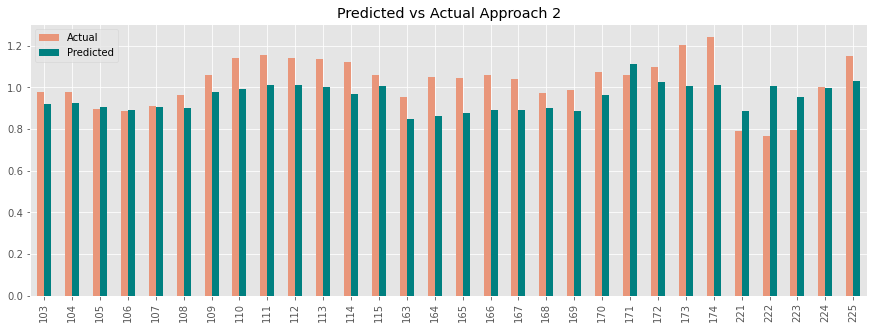

In [1116]:
aux_plot_real_vs_pred(1, y_test_appch2, y_pred_2_lgb)

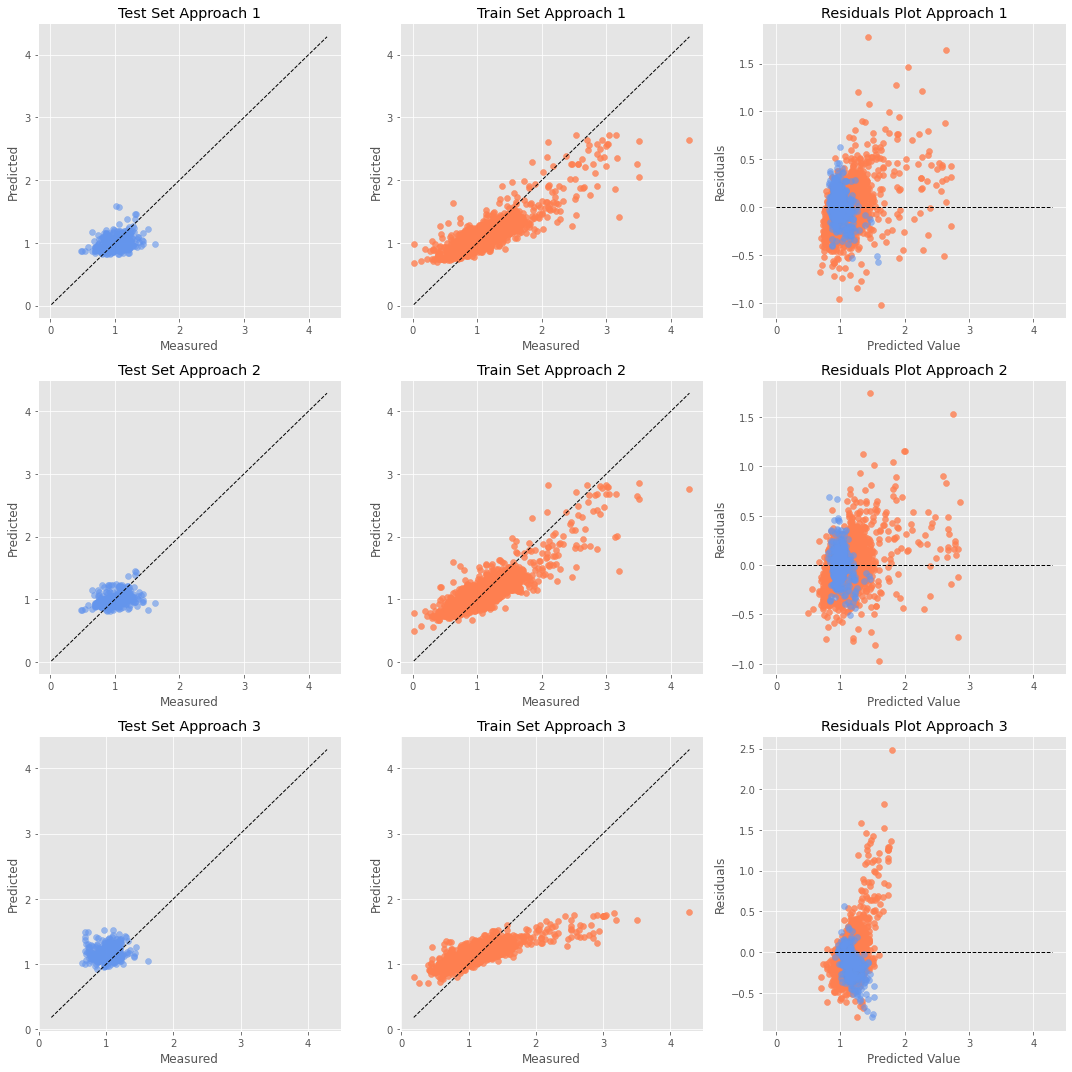

In [1117]:
fig, ax = plt.subplots(3,3,figsize=(15,15))

plot_aux(0, y_test_appch1, y_pred_1_lgb, y_train_appch1, y_pred_train_1_lgb, ax)
plot_aux(1, y_test_appch2, y_pred_2_lgb, y_train_appch2, y_pred_train_2_lgb, ax)
plot_aux(2, y_test_appch3, y_pred_3_lgb, y_train_appch3, y_pred_train_3_lgb, ax)

fig.tight_layout()
plt.show()

* As seen **Approach 2** together with Approach 1 seems to be getting the best result in the test set and is the one getting the best fit to the predicted-measured line.
* Approach 3 seems to be getting bad results. 
* However this model seems to be getting **better results than XGB** in general terms, however we will analyz this in further detail later on. 
* It is also important to note that **test set has a smaller range of values (0.5,1.5) than the train set (0, 4.5)** and its concentration and variance is higher.
* There are no signs of overfitting based on the plots shown together with the analysis in the residuals plot.

## Gradient Boosting Regressor 
Parameter selection has been done over try and error in order to avoid under-fitting or over-fitting. In this case we have selected **max_depth to be 5** in order to avoid over-fitting.

In [1303]:
reg1_gbr = GradientBoostingRegressor(max_depth=4)
reg2_gbr = GradientBoostingRegressor(max_depth=4)
reg3_gbr = GradientBoostingRegressor(max_depth=4)

reg1_gbr.fit(X_train_appch1_clean, y_train_appch1_clean)
reg2_gbr.fit(X_train_appch2_clean, y_train_appch2_clean)
reg3_gbr.fit(X_train_appch3_clean, y_train_appch3_clean)


y_pred_1_gbr=reg1_gbr.predict(X_test_appch1_clean)
y_pred_train_1_gbr=reg1_gbr.predict(X_train_appch1_clean)
y_pred_2_gbr=reg2_gbr.predict(X_test_appch2_clean)
y_pred_train_2_gbr=reg2_gbr.predict(X_train_appch2_clean)
y_pred_3_gbr=reg3_gbr.predict(X_test_appch3_clean)
y_pred_train_3_gbr=reg3_gbr.predict(X_train_appch3_clean)

### Evaluation

#### Test Set

In [1304]:
df_scores_gbr=get_metrics_data_frame(y_test_appch1_clean,y_pred_1_gbr, y_test_appch2_clean, y_pred_2_gbr,y_test_appch3_clean, y_pred_3_gbr)
df_eval_approach_2.loc['Gradient Boosting'] = df_scores_gbr.loc['Approach 2']
highlight_min(df_scores_gbr)

,mae,mse,rmse,mape,r2
Approach 1,0.159790,0.038446,0.196077,15.837904,-0.302023
Approach 2,0.145037,0.033513,0.183065,14.752870,-0.134947
Approach 3,0.241339,0.102198,0.319684,26.294752,-2.850664


#### Train Set

In [1305]:
df_scores_train_gbr=get_metrics_data_frame(y_train_appch1_clean,y_pred_train_1_gbr, y_train_appch2_clean, y_pred_train_2_gbr,y_train_appch3_clean, y_pred_train_3_gbr)
highlight_min(df_scores_train_gbr)


,mae,mse,rmse,mape,r2
Approach 1,0.123752,0.027889,0.167000,13.733247,0.838093
Approach 2,0.129608,0.030212,0.173815,13.818528,0.824609
Approach 3,0.150384,0.044028,0.209828,14.485499,0.745727


## Results View

#### Actual vs Predicted

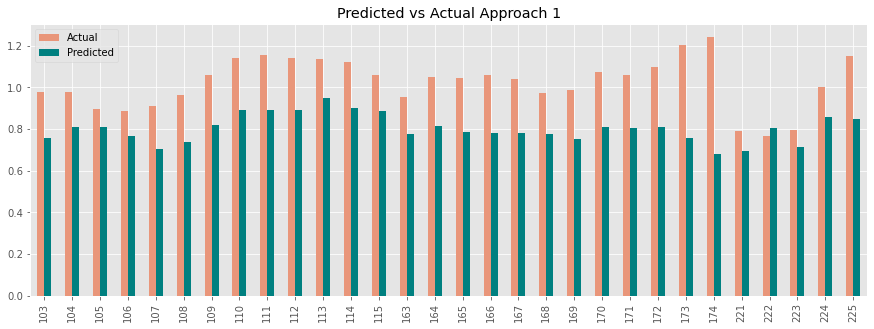

In [1306]:
aux_plot_real_vs_pred(0, y_test_appch1_clean, y_pred_1_gbr)

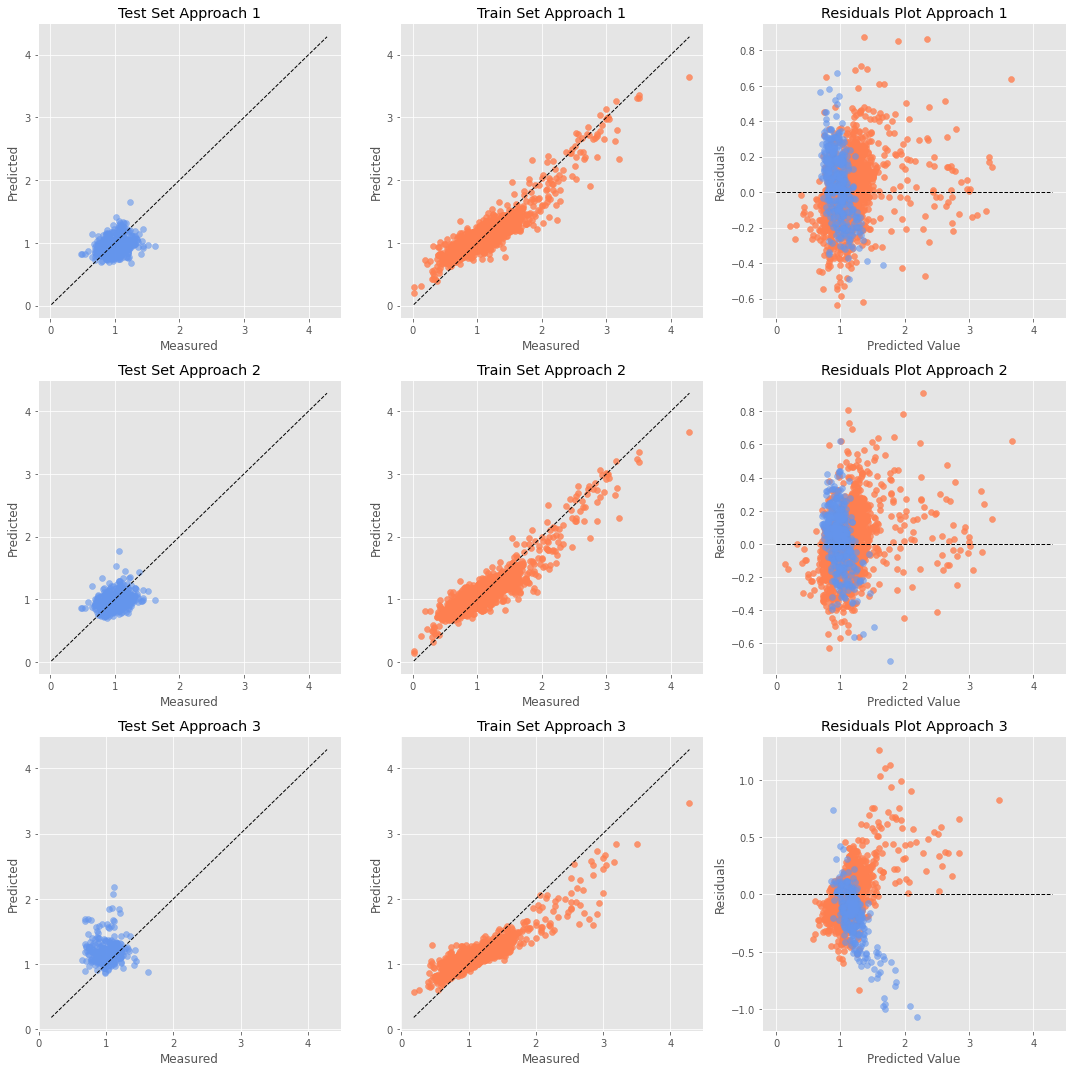

In [1307]:
fig, ax = plt.subplots(3,3,figsize=(15,15))

plot_aux(0, y_test_appch1_clean, y_pred_1_gbr, y_train_appch1_clean, y_pred_train_1_gbr, ax)
plot_aux(1, y_test_appch2_clean, y_pred_2_gbr, y_train_appch2_clean, y_pred_train_2_gbr, ax)
plot_aux(2, y_test_appch3_clean, y_pred_3_gbr, y_train_appch3_clean, y_pred_train_3_gbr, ax)

fig.tight_layout()
plt.show()

* As seen **Approach 2** together with Approach 1 seems to be getting the best result in the test set and is the one getting the best fit to the predicted-measured line.
* Approach 3 seems to be getting bad results. 
* However this model seems to be getting **better results than XGB and LGBM** in general terms, however we will analyze this in further detail later on. But we can appreciate a good fit of approach 1 and 2  that seems to be better than previous models.
* It is also important to note that the **test set has a smaller range of values (0.5, 1.5) than the train set (0, 4.5)** and its concentration and variance is higher.
* There are no signs of overfitting based on the plots shown together with the analysis in the residuals plot.

## K Nearest Neighbour Regressor
Parameter selection has been done over try and error in order to avoid under-fitting or over-fitting. In this case we have selected **n_neighbours to be 5** in order to avoid over-fitting.

In [1047]:
reg1_knn = KNeighborsRegressor(n_neighbors=5)
reg2_knn = KNeighborsRegressor(n_neighbors=5)
reg3_knn = KNeighborsRegressor(n_neighbors=5)

reg1_knn.fit(X_train_appch1_clean, y_train_appch1_clean)
reg2_knn.fit(X_train_appch2_clean, y_train_appch2_clean)
reg3_knn.fit(X_train_appch3_clean, y_train_appch3_clean)

y_pred_1_knn=reg1_knn.predict(X_test_appch1_clean)
y_pred_train_1_knn=reg1_knn.predict(X_train_appch1_clean)
y_pred_2_knn=reg2_knn.predict(X_test_appch2_clean)
y_pred_train_2_knn=reg2_knn.predict(X_train_appch2_clean)
y_pred_3_knn=reg3_knn.predict(X_test_appch3_clean)
y_pred_train_3_knn=reg3_knn.predict(X_train_appch3_clean)

### Evaluation

#### Test Set

In [1048]:
df_scores_knn=get_metrics_data_frame(y_test_appch1_clean,y_pred_1_knn, y_test_appch2_clean, y_pred_2_knn,y_test_appch3_clean, y_pred_3_knn)
df_eval_approach_2.loc['KNN'] = df_scores_knn.loc['Approach 2']
highlight_min(df_scores_knn)

,mae,mse,rmse,mape,r2
Approach 1,0.177105,0.049558,0.222615,18.482048,-0.678324
Approach 2,0.177699,0.049581,0.222667,18.478971,-0.679100
Approach 3,0.243031,0.108280,0.329060,25.738554,-3.079838


#### Train Set

In [1049]:
df_scores_knn_train=get_metrics_data_frame(y_train_appch1_clean,y_pred_train_1_knn, y_train_appch2_clean, y_pred_train_2_knn,y_train_appch3_clean, y_pred_train_3_knn)
highlight_min(df_scores_knn_train)

,mae,mse,rmse,mape,r2
Approach 1,0.144397,0.055860,0.236347,16.580836,0.675710
Approach 2,0.148454,0.054315,0.233056,16.900005,0.684677
Approach 3,0.170020,0.074373,0.272715,15.448068,0.570472


## Results View

#### Actual vs Predicted

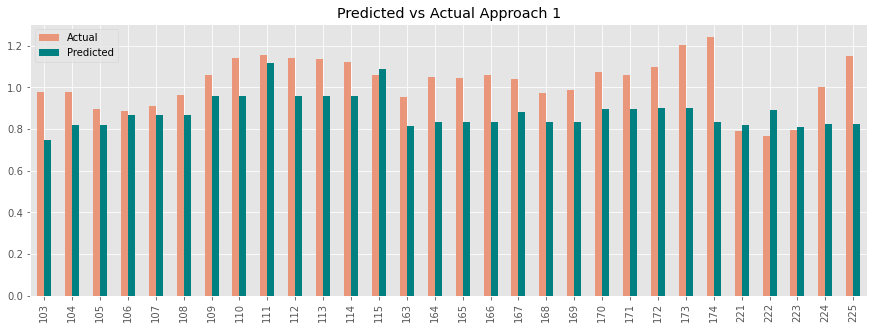

In [1050]:
aux_plot_real_vs_pred(0, y_test_appch1_clean, y_pred_1_knn)

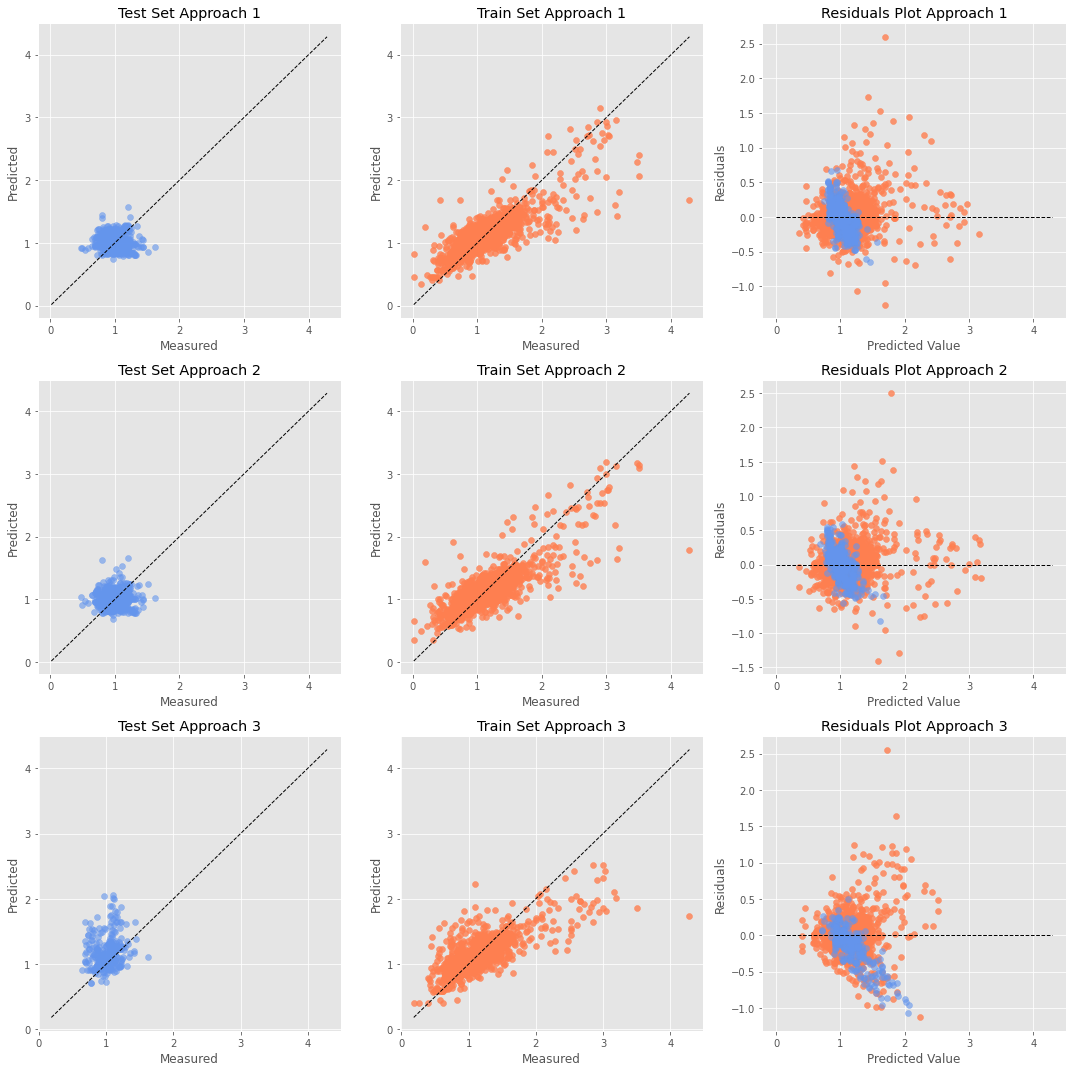

In [1051]:
fig, ax = plt.subplots(3,3,figsize=(15,15))

plot_aux(0, y_test_appch1_clean, y_pred_1_knn, y_train_appch1_clean, y_pred_train_1_knn, ax)
plot_aux(1, y_test_appch2_clean, y_pred_2_knn, y_train_appch2_clean, y_pred_train_2_knn, ax)
plot_aux(2, y_test_appch3_clean, y_pred_3_knn, y_train_appch3_clean, y_pred_train_3_knn, ax)

fig.tight_layout()
plt.show()

* As seen Approach 2 together with Approach 1 seems to be getting the best result in the test set and is the one getting the best fit to the predicted-measured line.
* Approach 3 seems to be getting bad results. 
* However this model seems to be getting **worse results than XGB, LGBM and Gradient Boosting**, we will analyze this in further detail later on. 
* It is also important to note that the **test set has a smaller range of values (0.5, 1.5) than the train set (0, 4.5)** and its concentration and variance is higher.
* There are no signs of overfitting based on the plots shown together with the analysis in the residuals plot.

## Histogram Gradient Boosting Regressor
Parameter selection has been done over try and error in order to avoid under-fitting or over-fitting. In this case we have selected **max_depth to be 4** in order to avoid over-fitting.

In [1052]:
reg1_hist = HistGradientBoostingRegressor(max_depth=3)
reg2_hist = HistGradientBoostingRegressor(max_depth=3)
reg3_hist = HistGradientBoostingRegressor(max_depth=3)

reg1_hist.fit(X_train_appch1_clean, y_train_appch1_clean)
reg2_hist.fit(X_train_appch2_clean, y_train_appch2_clean)
reg3_hist.fit(X_train_appch3_clean, y_train_appch3_clean)

y_pred_1_hist=reg1_hist.predict(X_test_appch1_clean)
y_pred_train_1_hist=reg1_hist.predict(X_train_appch1_clean)
y_pred_2_hist=reg2_hist.predict(X_test_appch2_clean)
y_pred_train_2_hist=reg2_hist.predict(X_train_appch2_clean)
y_pred_3_hist=reg3_hist.predict(X_test_appch3_clean)
y_pred_train_3_hist=reg3_hist.predict(X_train_appch3_clean)

### Evaluation

#### Test Set

In [1053]:
df_scores_hist=get_metrics_data_frame(y_test_appch1_clean,y_pred_1_hist, y_test_appch2_clean, y_pred_2_hist,y_test_appch3_clean, y_pred_3_hist)
df_eval_approach_2.loc['Histogram Gradient Boosting'] = df_scores_hist.loc['Approach 2']
highlight_min(df_scores_hist)

,mae,mse,rmse,mape,r2
Approach 1,0.152514,0.036828,0.191906,15.096345,-0.247224
Approach 2,0.140288,0.031053,0.176218,13.945578,-0.051633
Approach 3,0.217084,0.079290,0.281585,23.988227,-1.987534


#### Train Set

In [1054]:
df_scores_hist_train=get_metrics_data_frame(y_train_appch1_clean,y_pred_train_1_hist, y_train_appch2_clean, y_pred_train_2_hist,y_train_appch3_clean, y_pred_train_3_hist)
highlight_min(df_scores_hist_train)

,mae,mse,rmse,mape,r2
Approach 1,0.162338,0.051937,0.227898,18.957634,0.698481
Approach 2,0.166248,0.054448,0.233341,19.040259,0.683907
Approach 3,0.208912,0.099456,0.315367,19.581169,0.425610


## Results View

#### Actual vs Predicted

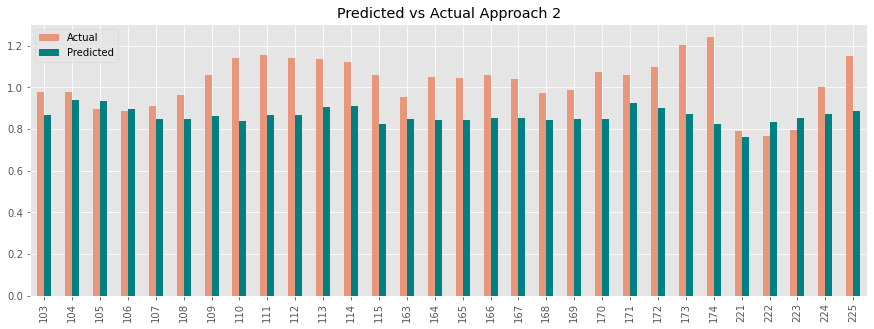

In [1055]:
aux_plot_real_vs_pred(1, y_test_appch2_clean, y_pred_2_hist)

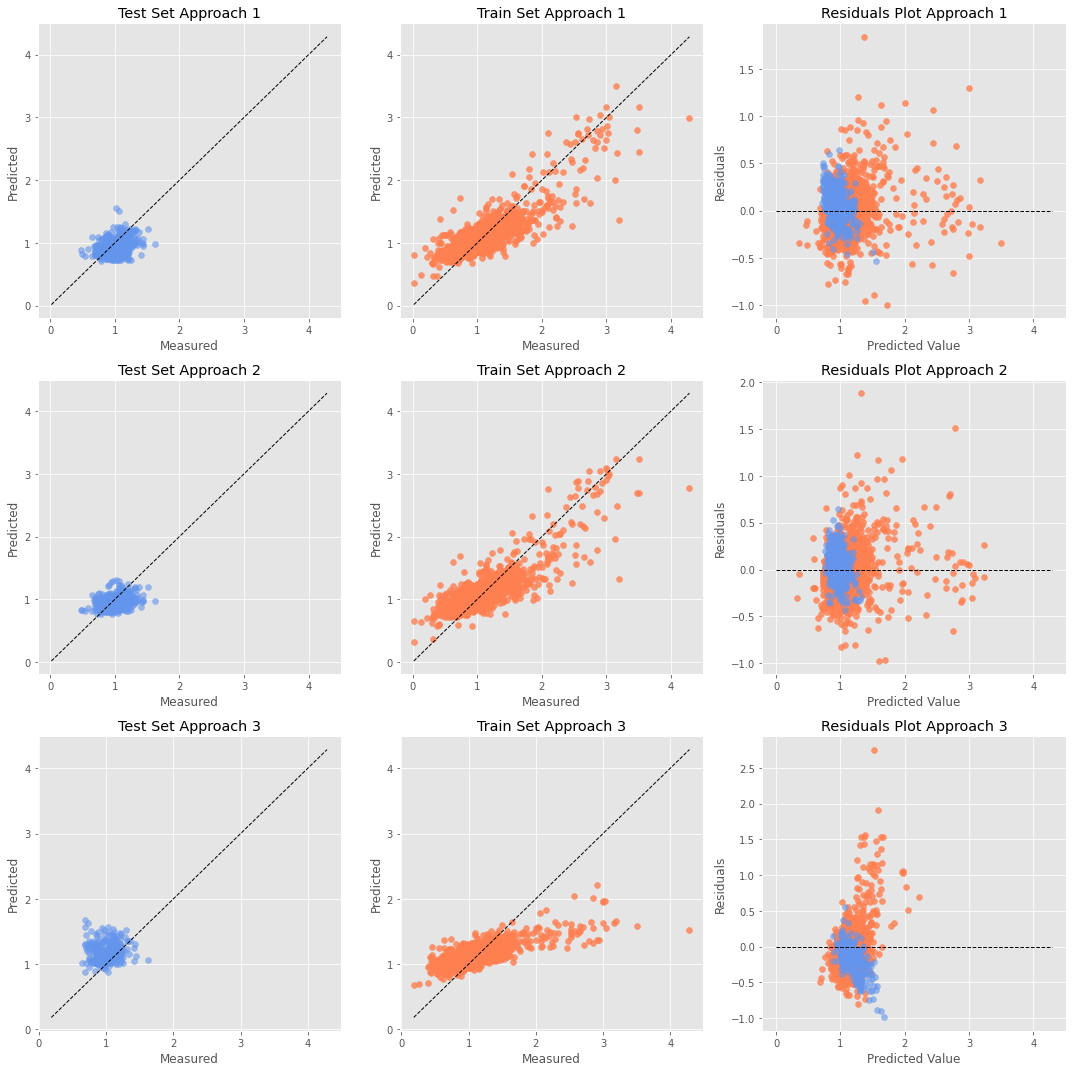

In [1056]:
fig, ax = plt.subplots(3,3,figsize=(15,15))

plot_aux(0, y_test_appch1_clean, y_pred_1_hist, y_train_appch1_clean, y_pred_train_1_hist, ax)
plot_aux(1, y_test_appch2_clean, y_pred_2_hist, y_train_appch2_clean, y_pred_train_2_hist, ax)
plot_aux(2, y_test_appch3_clean, y_pred_3_hist, y_train_appch3_clean, y_pred_train_3_hist, ax)

fig.tight_layout()
plt.show()

* As seen Approach 2 together with Approach 1 seems to be getting the best result in the test set and is the one getting the best fit to the predicted-measured line.
* Approach 3 seems to be getting bad results. 
* However this model seems to be getting **simillar results than XGB, LGBM and Gradient Boosting**, we will analyze this in further detail later on. 
* It is also important to note that the **test set has a smaller range of values (0.5, 1.5) than the train set (0, 4.5)** and its concentration and variance is higher.
* There are no signs of overfitting based on the plots shown together with the analysis in the residuals plot.

## NuSVR

In [1057]:
from sklearn.svm import NuSVR
reg1_nusvr = NuSVR(C=1.0, nu=0.1)
reg2_nusvr = NuSVR(C=1.0, nu=0.1)
reg3_nusvr = NuSVR(C=1.0, nu=0.1)

reg1_nusvr.fit(X_train_appch1_clean, y_train_appch1_clean)
reg2_nusvr.fit(X_train_appch2_clean, y_train_appch2_clean)
reg3_nusvr.fit(X_train_appch3_clean, y_train_appch3_clean)

y_pred_1_nusvr=reg1_nusvr.predict(X_test_appch1_clean)
y_pred_train_1_nusvr=reg1_nusvr.predict(X_train_appch1_clean)
y_pred_2_nusvr=reg2_nusvr.predict(X_test_appch2_clean)
y_pred_train_2_nusvr=reg2_nusvr.predict(X_train_appch2_clean)
y_pred_3_nusvr=reg3_nusvr.predict(X_test_appch3_clean)
y_pred_train_3_nusvr=reg3_nusvr.predict(X_train_appch3_clean)

### Evaluation

#### Test Set

In [1058]:
df_scores_NuSVR=get_metrics_data_frame(y_test_appch1_clean,y_pred_1_nusvr, y_test_appch2_clean, y_pred_2_nusvr,y_test_appch3_clean, y_pred_3_nusvr)
df_eval_approach_2.loc['NuSVR'] = df_scores_NuSVR.loc['Approach 2']
highlight_min(df_scores_NuSVR)

,mae,mse,rmse,mape,r2
Approach 1,0.187102,0.054880,0.234265,20.068736,-0.858568
Approach 2,0.184975,0.053336,0.230945,20.191336,-0.806267
Approach 3,0.248770,0.092551,0.304222,27.272512,-2.487171


#### Train Set

In [1059]:
df_scores_NuSVR_train=get_metrics_data_frame(y_train_appch1_clean,y_pred_train_1_nusvr, y_train_appch2_clean, y_pred_train_2_nusvr,y_train_appch3_clean, y_pred_train_3_nusvr)
highlight_min(df_scores_NuSVR_train)

,mae,mse,rmse,mape,r2
Approach 1,0.195519,0.060573,0.246115,22.254591,0.648350
Approach 2,0.207621,0.072194,0.268690,23.585251,0.580882
Approach 3,0.257644,0.122226,0.349608,25.100984,0.294109


## Results View

#### Actual vs Predicted

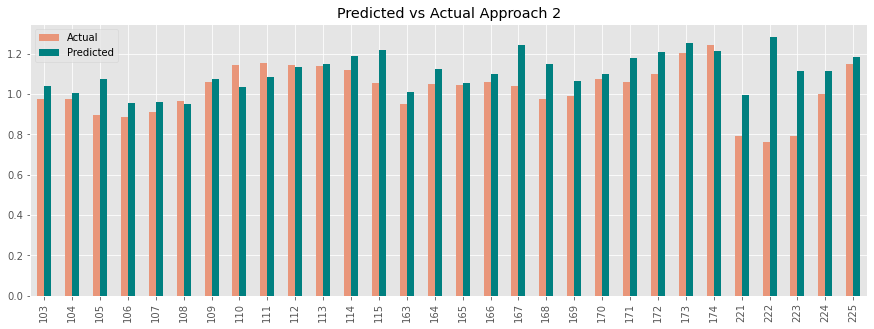

In [1060]:
aux_plot_real_vs_pred(1, y_test_appch2_clean, y_pred_2_nusvr)

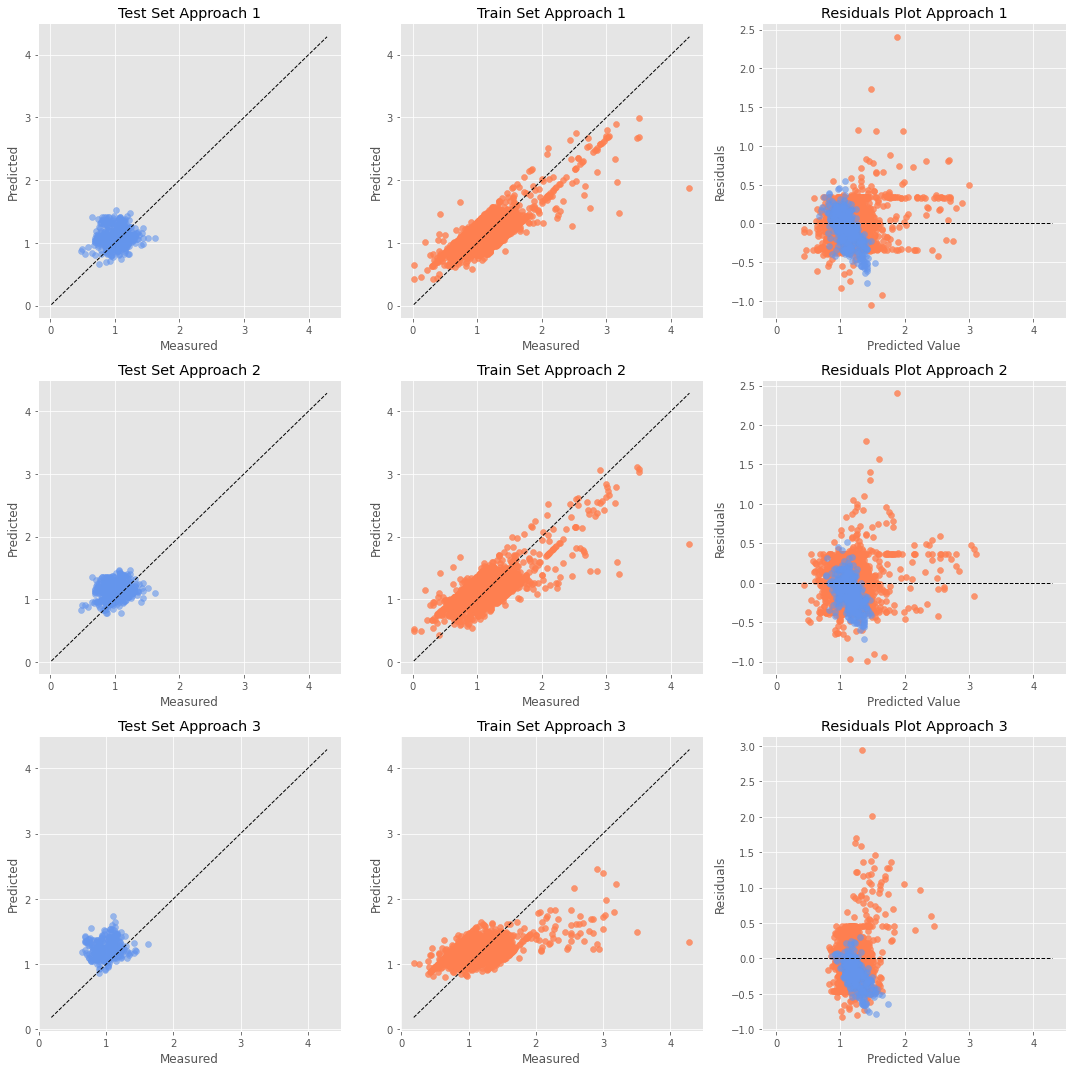

In [1061]:
fig, ax = plt.subplots(3,3,figsize=(15,15))

plot_aux(0, y_test_appch1_clean, y_pred_1_nusvr, y_train_appch1_clean, y_pred_train_1_nusvr, ax)
plot_aux(1, y_test_appch2_clean, y_pred_2_nusvr, y_train_appch2_clean, y_pred_train_2_nusvr, ax)
plot_aux(2, y_test_appch3_clean, y_pred_3_nusvr, y_train_appch3_clean, y_pred_train_3_nusvr, ax)

fig.tight_layout()
plt.show()

* As seen Approach 2 together with Approach 1 seems to be getting the best result in the test set and is the one getting the best fit to the predicted-measured line.
* Approach 3 seems to be getting bad results. 
* However this model seems to be getting **worse results than XGB, LGBM, Gradient Boosting and Histogram Gradient Boosting**, we will analyze this in further detail later on. 
* It is also important to note that the **test set has a smaller range of values (0.5, 1.5) than the train set (0, 4.5)** and its concentration and variance is higher.
* There are no signs of overfitting based on the plots shown together with the analysis in the residuals plot.

## Comparing Three Models with Three Approaches
Once we have an intuition and individual evaluation of each model we will look at all models with the three different approaches in order to asses best and worse results, and which approach seems to be the best. 

In [1062]:
xgb_mae, lgb_mae, gbst_mae, knn_mae, hist_mae, NuSVR_mae = get_values_metric('mae')
xgb_mse, lgb_mse, gbst_mse, knn_mse, hist_mae, NuSVR_mae = get_values_metric('mse')
xgb_rmse, lgb_rmse, gbst_rmse, knn_rmse, hist_mae, NuSVR_mae = get_values_metric('rmse')
xgb_mape, lgb_mape, gbst_mape, knn_mape, hist_mae, NuSVR_mae = get_values_metric('mape')

xgb_mae=xgb_mae.sort_index(ascending=False)
lgb_mae=lgb_mae.sort_index(ascending=False)
gbst_mae=gbst_mae.sort_index(ascending=False)
knn_mae=knn_mae.sort_index(ascending=False)
hist_mae=knn_mae.sort_index(ascending=False)
NuSVR_mae=knn_mae.sort_index(ascending=False)

xgb_mse=xgb_mse.sort_index(ascending=False)
lgb_mse=lgb_mse.sort_index(ascending=False)
gbst_mse=gbst_mse.sort_index(ascending=False)
knn_mse=knn_mse.sort_index(ascending=False)
hist_mse=knn_mse.sort_index(ascending=False)
NuSVR_mse=knn_mse.sort_index(ascending=False)

xgb_rmse=xgb_rmse.sort_index(ascending=False)
lgb_rmse=lgb_rmse.sort_index(ascending=False)
gbst_rmse=gbst_rmse.sort_index(ascending=False)
knn_rmse=knn_rmse.sort_index(ascending=False)
hist_rmse=knn_rmse.sort_index(ascending=False)
NuSVR_rmse=knn_rmse.sort_index(ascending=False)

xgb_mape=xgb_mape.sort_index(ascending=False)
lgb_mape=lgb_mape.sort_index(ascending=False)
gbst_mape=gbst_mape.sort_index(ascending=False)
knn_mape=knn_mape.sort_index(ascending=False)
hist_mape=knn_mape.sort_index(ascending=False)
NuSVR_mape=knn_mape.sort_index(ascending=False)

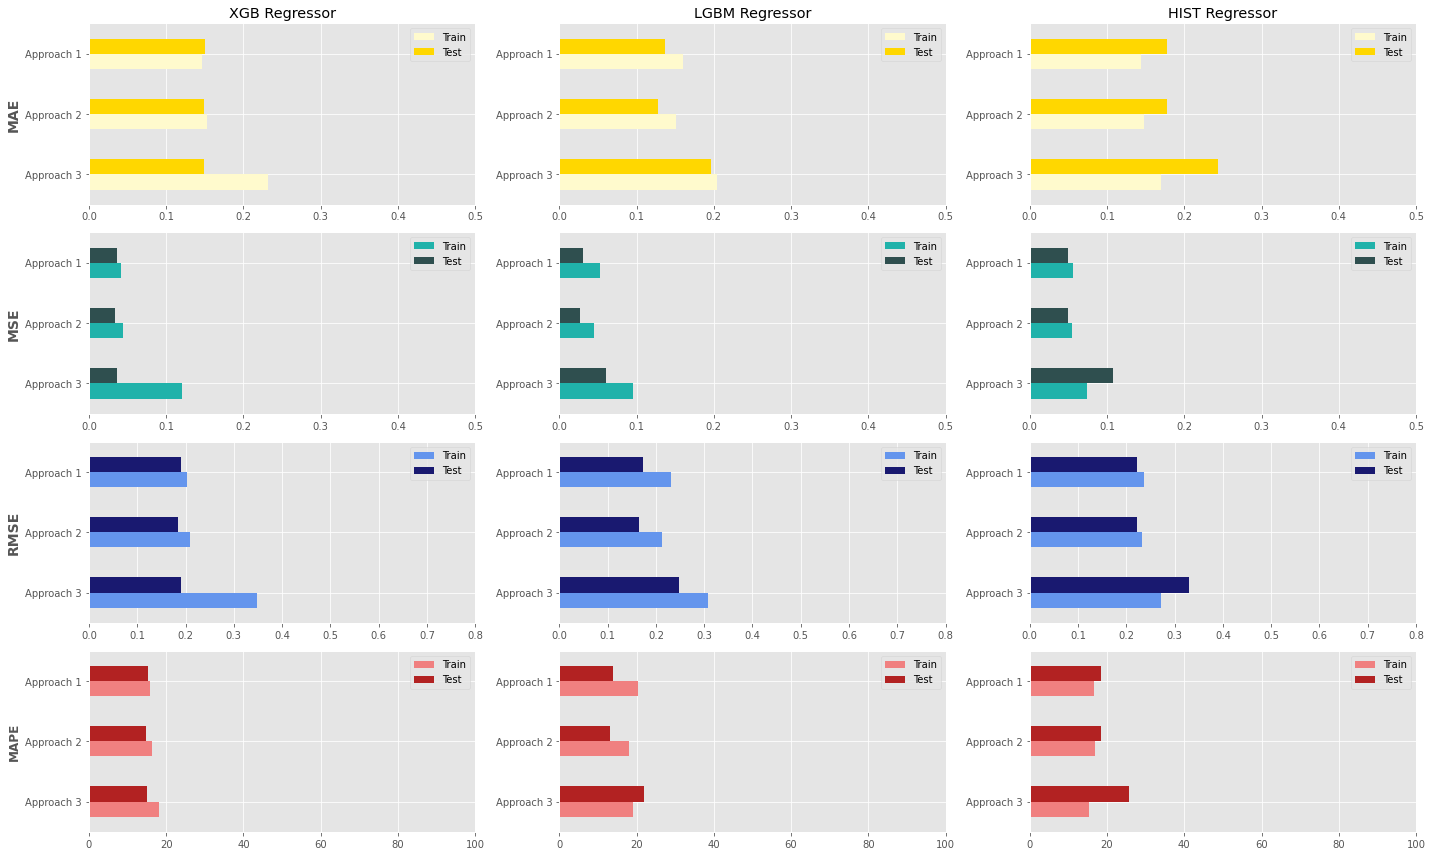

In [1063]:
fig, ax = plt.subplots(4,3,figsize=(20,12))

xgb_mae.plot.barh(ax=ax[0][0], color=["lemonchiffon","gold"],title = 'XGB Regressor').set_ylabel('MAE', fontsize=14.0, fontweight='bold')
lgb_mae.plot.barh(ax=ax[0][1], color=["lemonchiffon","gold"],title = 'LGBM Regressor')
hist_mae.plot.barh(ax=ax[0][2], color=["lemonchiffon","gold"],title = 'HIST Regressor')
xgb_mse.plot.barh(ax=ax[1][0], color=["lightseagreen","darkslategray"]).set_ylabel('MSE', fontsize=14.0, fontweight='bold')
lgb_mse.plot.barh(ax=ax[1][1], color=["lightseagreen","darkslategray"])
hist_mse.plot.barh(ax=ax[1][2], color=["lightseagreen","darkslategray"])
xgb_rmse.plot.barh(ax=ax[2][0], color=["cornflowerblue","midnightblue"]).set_ylabel('RMSE', fontsize=14.0, fontweight='bold')
lgb_rmse.plot.barh(ax=ax[2][1], color=["cornflowerblue","midnightblue"])
hist_rmse.plot.barh(ax=ax[2][2], color=["cornflowerblue","midnightblue"])
xgb_mape.plot.barh(ax=ax[3][0], color=["lightcoral","firebrick"]).set_ylabel('MAPE',fontsize=12.0, fontweight='bold')
lgb_mape.plot.barh(ax=ax[3][1], color=["lightcoral","firebrick"])
hist_mape.plot.barh(ax=ax[3][2], color=["lightcoral","firebrick"])

ax[0][0].set_xlim([0, 0.5])
ax[0][1].set_xlim([0, 0.5])
ax[0][2].set_xlim([0, 0.5])

ax[1][0].set_xlim([0, 0.5])
ax[1][1].set_xlim([0, 0.5])
ax[1][2].set_xlim([0, 0.5])

ax[2][0].set_xlim([0, 0.8])
ax[2][1].set_xlim([0, 0.8])
ax[2][2].set_xlim([0, 0.8])

ax[3][0].set_xlim([0, 100])
ax[3][1].set_xlim([0, 100])
ax[3][2].set_xlim([0, 100])

fig.tight_layout()

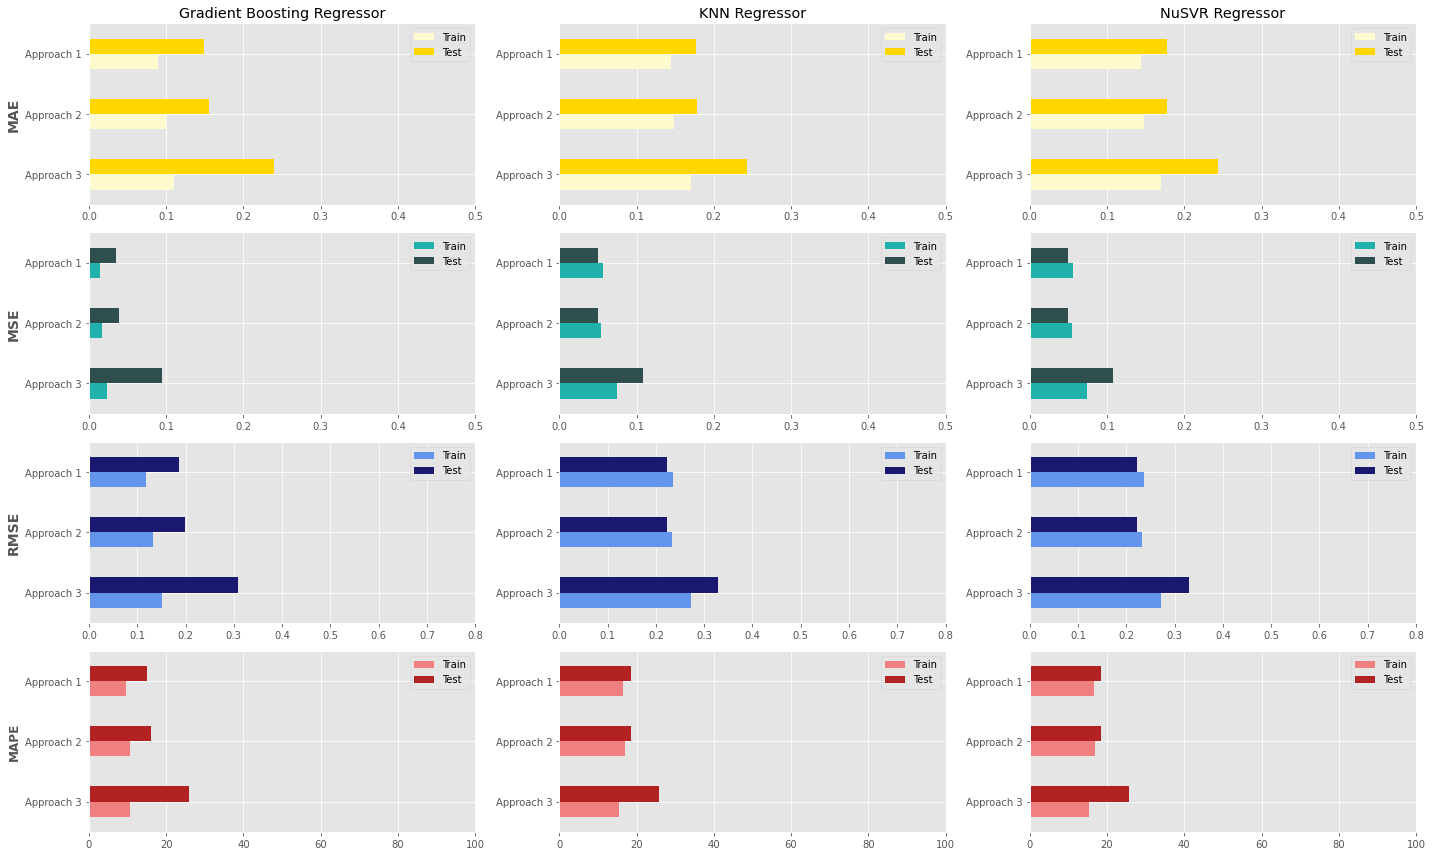

In [1064]:
fig, ax = plt.subplots(4,3,figsize=(20,12))

gbst_mae.plot.barh(ax=ax[0][0], color=["lemonchiffon","gold"],title = 'Gradient Boosting Regressor').set_ylabel('MAE', fontsize=14.0, fontweight='bold')
knn_mae.plot.barh(ax=ax[0][1], color=["lemonchiffon","gold"],title = 'KNN Regressor')
NuSVR_mae.plot.barh(ax=ax[0][2], color=["lemonchiffon","gold"],title = 'NuSVR Regressor')
gbst_mse.plot.barh(ax=ax[1][0], color=["lightseagreen","darkslategray"]).set_ylabel('MSE', fontsize=14.0, fontweight='bold')
knn_mse.plot.barh(ax=ax[1][1], color=["lightseagreen","darkslategray"])
NuSVR_mse.plot.barh(ax=ax[1][2], color=["lightseagreen","darkslategray"])
gbst_rmse.plot.barh(ax=ax[2][0], color=["cornflowerblue","midnightblue"]).set_ylabel('RMSE', fontsize=14.0, fontweight='bold')
knn_rmse.plot.barh(ax=ax[2][1], color=["cornflowerblue","midnightblue"])
NuSVR_rmse.plot.barh(ax=ax[2][2], color=["cornflowerblue","midnightblue"])
gbst_mape.plot.barh(ax=ax[3][0], color=["lightcoral","firebrick"]).set_ylabel('MAPE',fontsize=12.0, fontweight='bold')
knn_mape.plot.barh(ax=ax[3][1], color=["lightcoral","firebrick"])
NuSVR_mape.plot.barh(ax=ax[3][2], color=["lightcoral","firebrick"])

ax[0][0].set_xlim([0, 0.5])
ax[0][1].set_xlim([0, 0.5])
ax[0][2].set_xlim([0, 0.5])

ax[1][0].set_xlim([0, 0.5])
ax[1][1].set_xlim([0, 0.5])
ax[1][2].set_xlim([0, 0.5])

ax[2][0].set_xlim([0, 0.8])
ax[2][1].set_xlim([0, 0.8])
ax[2][2].set_xlim([0, 0.8])

ax[3][0].set_xlim([0, 100])
ax[3][1].set_xlim([0, 100])
ax[3][2].set_xlim([0, 100])

fig.tight_layout()

* In conclusion, Approaches 1 and 2 seem to be getting the best results for all  six models.
* There are no signs of overfitting based on the metrics and residual plots visualized.
* Boosting models **(XGB, LGBM, Gradient boosting and Histogram Gradient Boosting)** seem to be getting the best results based on the fits and metrics observed. 8

## Evaluating Results for Approach 2
It has been stated that approaches 1 and 2 seem to be getting the best results. However we can appreciate a better fit to the measured-predicted line plot in all models. Approach 2 is getting the best results on the test set. Based on this two evidencies and on the fact that approach 2 is simpler and easier to understand in further analysis of SHAP values, and the importance of each future selected **we will select Approach 2** as mentioned before for our final model. Approach 2 has less variables but with more significance overall.

* As mentioned, approach 2 seems to be the most replicable and explainable model, therefore we will work with this model. 
* We will look at the metrics mae, mse, rmse and mape of all regressor used and compare them visually.

Text(0.5, 1.0, 'MAPE')

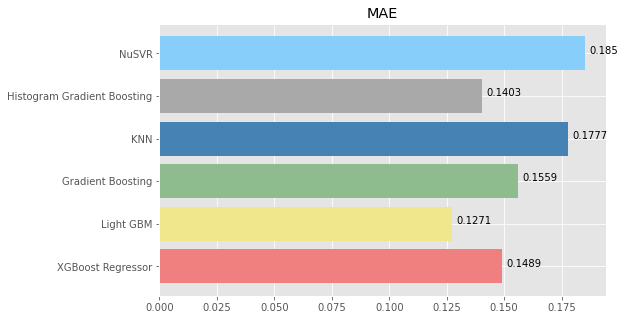

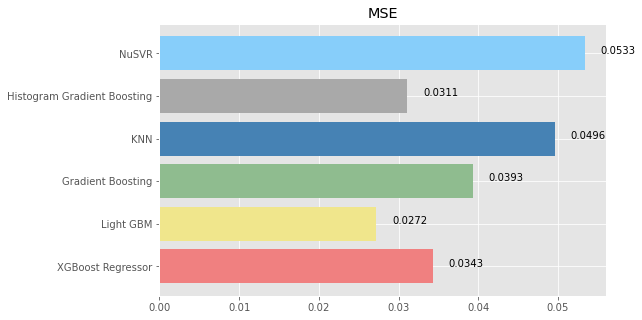

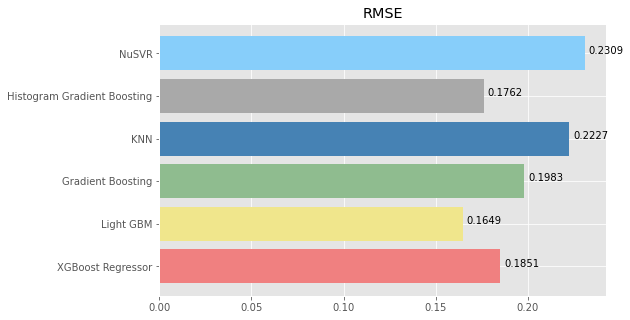

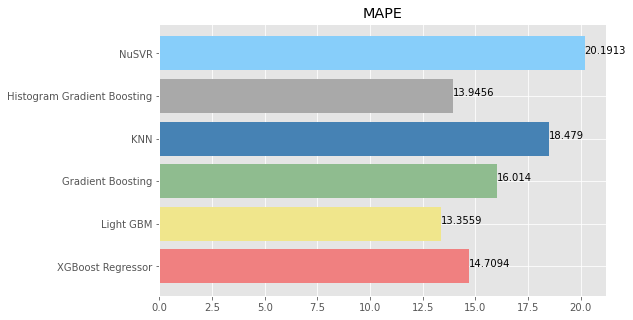

In [1118]:
colors = ['lightcoral', 'khaki', 'darkseagreen', 'steelblue', 'darkgray', 'lightskyblue']
y=np.round(df_eval_approach_2['mae'], decimals=4)

fig, ax = plt.subplots(figsize=(8, 5)) 
ind=np.arange(len(df_eval_approach_2))
ax.barh(ind, df_eval_approach_2['mae'], color=colors)
plt.yticks(ind,df_eval_approach_2.index.tolist())

for i, v in enumerate(y):
    ax.text(v+0.002, i, str(v), color='black')
ax.set_title('MAE')

y=np.round(df_eval_approach_2['mse'], decimals=4)

fig, ax = plt.subplots(figsize=(8, 5)) 
ind=np.arange(len(df_eval_approach_2))
ax.barh(ind, df_eval_approach_2['mse'], color=colors)
plt.yticks(ind,df_eval_approach_2.index.tolist())

for i, v in enumerate(y):
    ax.text(v+0.002, i, str(v), color='black')
ax.set_title('MSE')

y=np.round(df_eval_approach_2['rmse'], decimals=4)

fig, ax = plt.subplots(figsize=(8, 5)) 
ind=np.arange(len(df_eval_approach_2))
ax.barh(ind, df_eval_approach_2['rmse'], color=colors)
plt.yticks(ind,df_eval_approach_2.index.tolist())

for i, v in enumerate(y):
    ax.text(v+0.002, i, str(v), color='black')
ax.set_title('RMSE')

y=np.round(df_eval_approach_2['mape'], decimals=4)

fig, ax = plt.subplots(figsize=(8, 5)) 
ind=np.arange(len(df_eval_approach_2))
ax.barh(ind, df_eval_approach_2['mape'], color=colors)
plt.yticks(ind,df_eval_approach_2.index.tolist())

for i, v in enumerate(y):
    ax.text(v+0.002, i, str(v), color='black')
ax.set_title('MAPE')

Based on the metrics shown  it can be seen taht XGB, **LGBM, Gradient boosting and Histogram Gradient Boosting** are getting the best results, we will perform in detail analysis to them.

## Time Series Split Evaluation Approach 2
We decide to zoom in our predictions on the **test set range (0.5, 1.5)** in order to better visualizes fits of the models.

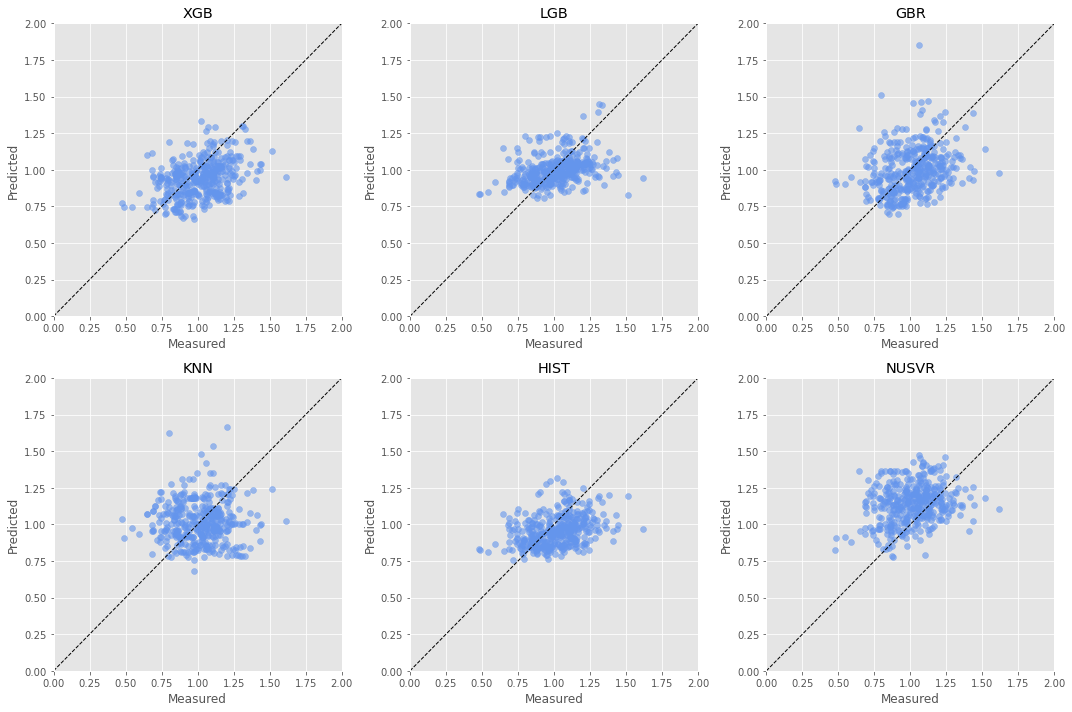

In [1119]:
fig, ax = plt.subplots(2,3,figsize=(15,10))

aux_plot_3('XGB', 0,0, y_test_appch2, y_pred_2_xgb, y_train_appch2, ax)
aux_plot_3('LGB', 0,1, y_test_appch2, y_pred_2_lgb, y_train_appch2, ax)
aux_plot_3('GBR', 0,2, y_test_appch2, y_pred_2_gbr, y_train_appch2, ax)
aux_plot_3('KNN', 1,0, y_test_appch2, y_pred_2_knn, y_train_appch2, ax)
aux_plot_3('HIST', 1,1, y_test_appch2, y_pred_2_hist, y_train_appch2, ax)
aux_plot_3('NUSVR', 1,2, y_test_appch2, y_pred_2_nusvr, y_train_appch2, ax)

fig.tight_layout()

It can be seen that the best approaches seem the ones obtained by the metrics. We will perform time series evaluation on the selected models.
* We will perform 6 splits, with the selected top models, and compare them.

### **Assesing the R2 mismatch between train and test
As seen in the predictions for the initial split of 2020 (train) 2021 (test) it can be seen that R2 socre highglydiffers for all three approaches in all models. However there is no sign of overfitting. So in order to understand this we will try to understand the R2 formula first and secondly evaluate what is happening with out train vs our dataset.

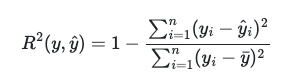

As seen on the right term of R2 there is a coefficient which in the denominator contains the equivalent to the sum of maes squared and on the denominator it contains the sum of the variance squared, the variance is divided by N, but this is a fixed term therefore it does not imply changes in the following analysis.

The main idea is that if the variance in both test and train are the same, then any changes in the value of R2 will mean that there is a difference in the predictions in train and test. In case of the mae been equivalent, therefore the predictions staying the same, it will be due to a difference in the variance of train ind test sets, which is our specific case. **R2 score is so different in train and test because the variation of values in train and test are widely different**.

In order to explain this lets just look at variance in test and train for the previous evaluation:


In [1173]:
np.var(y_train_appch2), np.var(y_test_appch2)

(0.17225297677258844, 0.029528047387486104)

As seen, variance in the trainset is 0.172 and variance in the test set is 0.029. This is a significant difference actually, it is 0.17/0.029=**5.86 times greater**

And this is the cause why our R2 score is so different in train and test, and this will be more appreciated in the later analysis when performing folds.

The reason behind this is that **governments are able to apply measures and restrictions in order to fit the desired reproduction rate of 1**, which by looking at the data seems to be the intention of governemnts worldwide. That has been appreciated in the plots as well, values **ranging from (0.5, 1.5)** for 2021 and values **ranging from (0.0, 4.5) in 2021**



## Time Series Train Test Split for XGB, LGBM, Gradient Boosting and Histogram Gradient Boosting
Once the mistmatch in R2 has been stated, let´s look at our evaluation of each model based on the time series train test split. 

In [1242]:
# Sort values by Date in order for the split to work
df_time=df_appch2_clean.copy()
df_time=df_time.sort_values('Date').reset_index()

In [1272]:
df_time

,index,Code,Date,mobility_index,residential,awareness_measures,health_measures,mobility_measures,economic_measures,closure_measures,holiday,temp,prcp,number_of_arrivals,urban_population,total_vaccinations_per_100,youth_unemployment,infections_value,accumulated,reproduction_rate
0,1871,KOR,2020-03-08,-10.636471,4.836857,0.4,2.500000,1.100000,0.0,1.742857,0.0,5.561562,0.181441,17242000.0,81.503,0.000000,9.820000,2.75,0.000872,4.285000
1,1637,ITA,2020-03-08,1.236729,0.173571,0.4,1.571429,1.671429,0.0,1.771429,0.0,6.668070,0.024724,52372000.0,70.144,0.000000,29.219999,8.14,0.000000,3.500000
2,762,DEU,2020-03-15,-0.891714,1.714286,0.4,1.500000,0.085714,0.0,0.942857,0.0,4.165919,0.051928,35555000.0,77.261,0.000000,5.750000,0.00,0.000000,3.030000
3,997,ESP,2020-03-15,2.091743,-0.693714,0.4,1.000000,0.000000,0.0,0.000000,0.0,11.962900,0.102814,75315000.0,80.080,0.000000,32.610001,10.43,0.000000,3.040000
4,1638,ITA,2020-03-15,-11.353171,4.163143,0.4,2.000000,2.500000,0.0,2.800000,0.0,4.950784,0.147998,52372000.0,70.144,0.000000,29.219999,37.79,0.000000,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2219,2492,NLD,2021-04-11,-34.628614,9.612000,2.0,1.500000,2.400000,1.5,2.000000,0.0,7.820202,0.030545,15828000.0,91.077,13.880000,6.770000,7.55,0.143015,1.105714
2220,1986,LTU,2021-04-11,-29.575543,6.551143,1.8,2.000000,2.400000,1.5,2.000000,0.0,5.707516,0.000000,2296000.0,67.516,17.807143,11.870000,10.99,0.249500,1.162857
2221,233,BGR,2021-04-11,-27.604043,6.285714,2.8,1.500000,1.200000,1.5,2.800000,0.0,4.517806,0.018974,8252000.0,74.669,6.358571,8.890000,72.75,0.367339,1.062857
2222,879,DNK,2021-04-18,-30.279571,9.510143,2.0,2.000000,1.900000,1.0,2.400000,4.0,5.646148,0.006575,10781000.0,87.757,20.524286,10.050000,0.00,0.049065,0.982857


### XGB Regressor

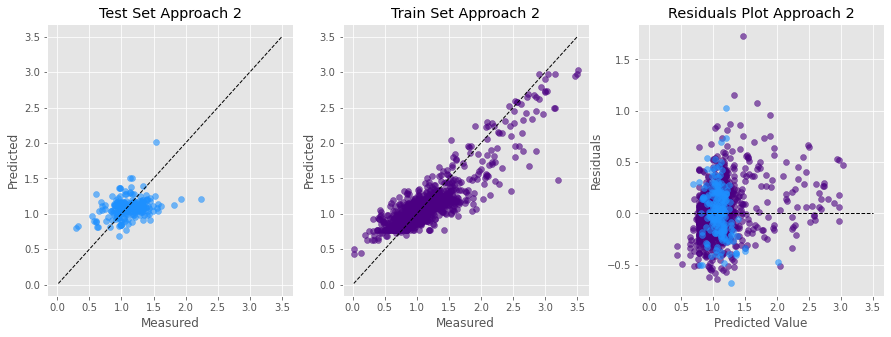

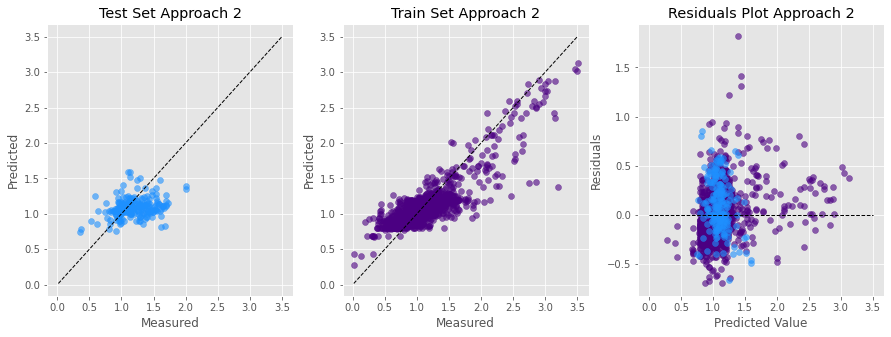

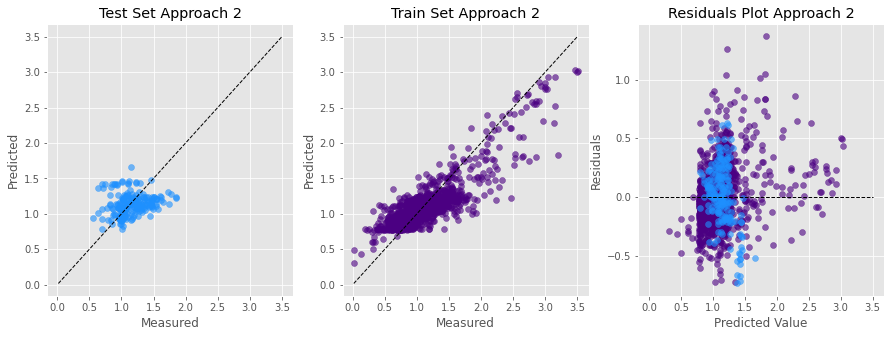

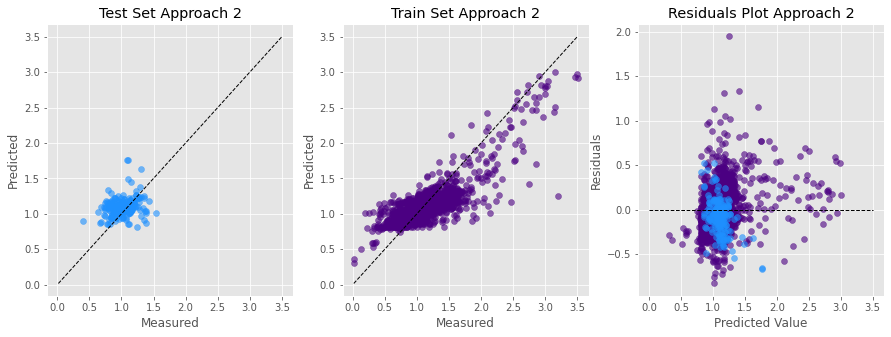

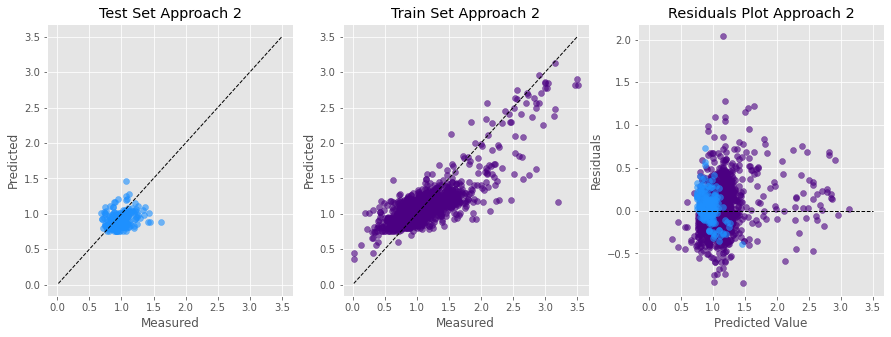

In [1281]:
model = XGBRegressor(max_depth=4,early_stopping_rounds=3, col_sample_by_tree=0.5, n_estimators=10)
df_xgb_met=time_test_split_custom(model)

In [1279]:
print('Average Test Mape: ' + str(df_xgb_met['mape'].mean()))
print('Average Test Mae: ' + str(df_xgb_met['mae'].mean()))

cm = sns.light_palette("green", as_cmap=True)
s = df_xgb_met.style.background_gradient(cmap=cm, subset=['std_test', 'std_train'])
s

Average Test Mape: 16.932011891231124
Average Test Mae: 0.17771687382743473


,mae,rmse,mse,mape,r2_test,r2_train,std_test,std_train
Fold 0,0.193905,0.247931,0.061470,19.081397,-1.953759,0.559093,0.063653,0.254550
Fold 1,0.227434,0.289831,0.084002,19.006234,-3.250769,0.429180,0.073906,0.222542
Fold 2,0.199204,0.256918,0.066007,18.142471,-1.992466,0.414601,0.057273,0.201260
Fold 3,0.154462,0.205488,0.042225,16.555618,-1.474299,0.246083,0.029842,0.183036
Fold 4,0.134109,0.176169,0.031036,13.296009,-1.501417,0.219149,0.024942,0.167733
Fold 5,0.157186,0.187663,0.035218,15.510343,-1.298600,0.225756,0.030924,0.155782


<AxesSubplot:>

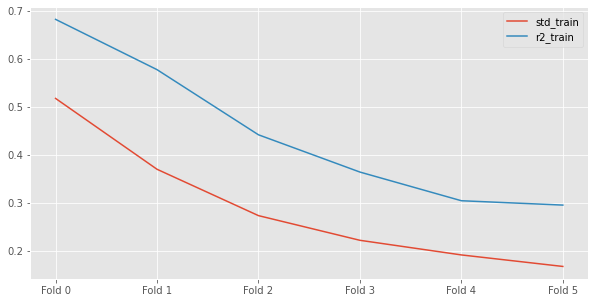

In [1223]:
plt.rcParams["figure.figsize"] = (10,5)
aux_df[['std_train','r2_train']].plot()

### LGBM Regressor

In [1228]:
y=df_time[df_time.columns[-1]]

scaler = preprocessing.StandardScaler().fit(df_time[df_time.columns[3:-1]])

X = pd.DataFrame(scaler.transform(df_time[df_time.columns[3:-1]]), columns=df_time.columns[3:-1])

aux_df=pd.DataFrame(columns=['mae', 'rmse', 'mse', 'mape', 'r2_test', 'r2_train', 'std_test', 'std_train'])

tscv = TimeSeriesSplit(n_splits=6)

iter = 0
for train_index, test_index in tscv.split(X): 
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]    
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = LGBRegressor(max_depth=4)
    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)
    y_pred_train=model.predict(X_train)
    
    fig, ax = plt.subplots(1,3,figsize=(15,5))
    plot_aux_2(1,y_test, y_pred, y_train, y_pred_train, ax)
    
    mae = mean_absolute_error(y_pred, y_test)
    rmse = np.sqrt(mean_squared_error(y_pred, y_test))
    mse = mean_squared_error(y_pred, y_test)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    mae = mean_absolute_error(y_pred, y_test)
    rmse = np.sqrt(mean_squared_error(y_pred, y_test))
    mse = mean_squared_error(y_pred, y_test)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    r2_train = r2_score(y_pred_train, y_train)
    r2_test = r2_score(y_pred, y_test)
    std_train = np.var(y_train)
    std_test = np.var(y_test)
    aux_df.loc['Fold ' + str(iter)]=[mae, rmse, mse, mape, r2_test, r2_train, std_test, std_train]
    iter = iter+1

NameError: name 'LGBRegressor' is not defined

In [1226]:
print('Average Test Mape: ' + str(aux_df['mape'].mean()))
print('Average Test Mae: ' + str(aux_df['mae'].mean()))
cm = sns.light_palette("green", as_cmap=True)
s = aux_df.style.background_gradient(cmap=cm, subset=['std_test', 'std_train'])
s

Average Test Mape: 19.669101803388532
Average Test Mae: 0.1562488212570407


,mae,rmse,mse,mape,r2_test,r2_train,std_test,std_train
Fold 0,0.185207,0.265072,0.070263,33.964401,-1.914974,0.681601,0.106006,0.516943
Fold 1,0.179116,0.250271,0.062636,29.713228,-4.524031,0.576861,0.076946,0.369385
Fold 2,0.152784,0.204388,0.041774,14.808292,-1.941857,0.441180,0.065329,0.272832
Fold 3,0.151814,0.195942,0.038393,12.491952,-1.191919,0.363567,0.067582,0.221446
Fold 4,0.112494,0.144599,0.020909,11.344199,-0.986635,0.303854,0.030007,0.190989
Fold 5,0.156078,0.194298,0.037752,15.692540,-1.550405,0.294770,0.028688,0.167001


<AxesSubplot:>

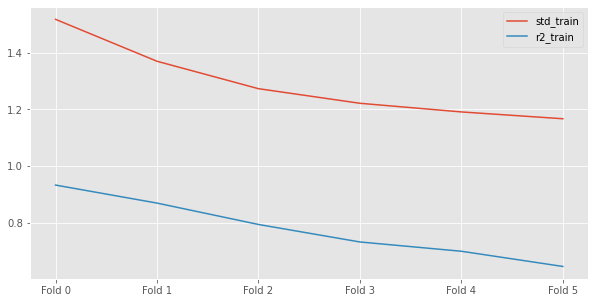

In [1153]:
plt.rcParams["figure.figsize"] = (10,5)
aux_df[['std_train','r2_train']].plot()

### Gradient Boosting

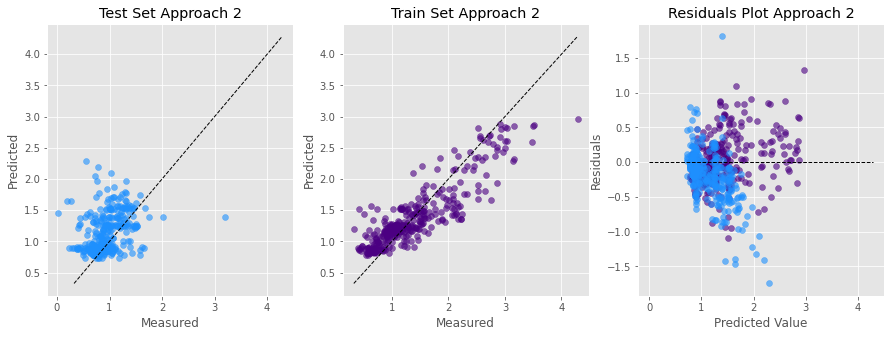

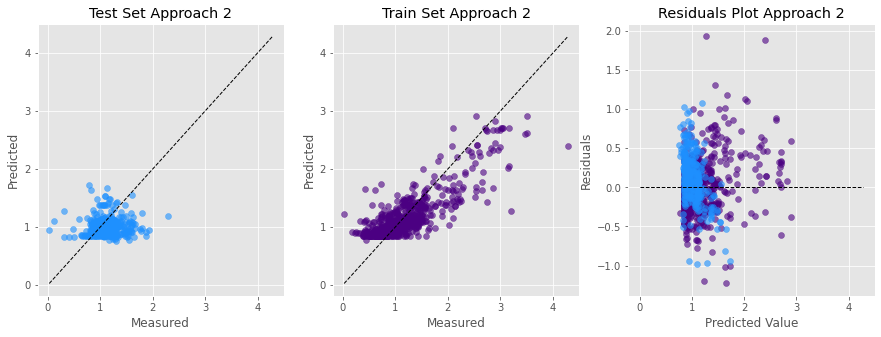

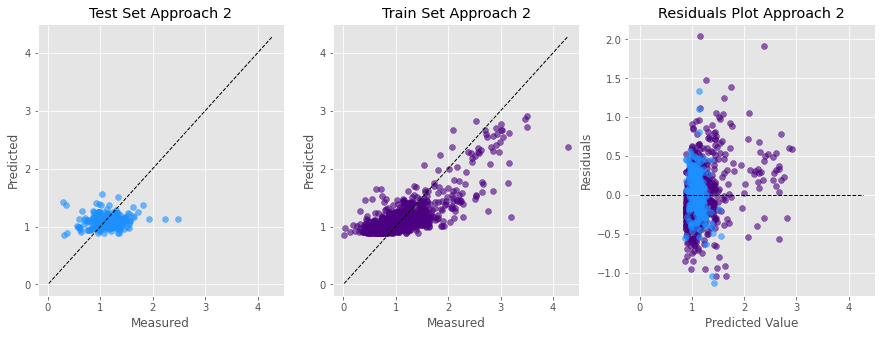

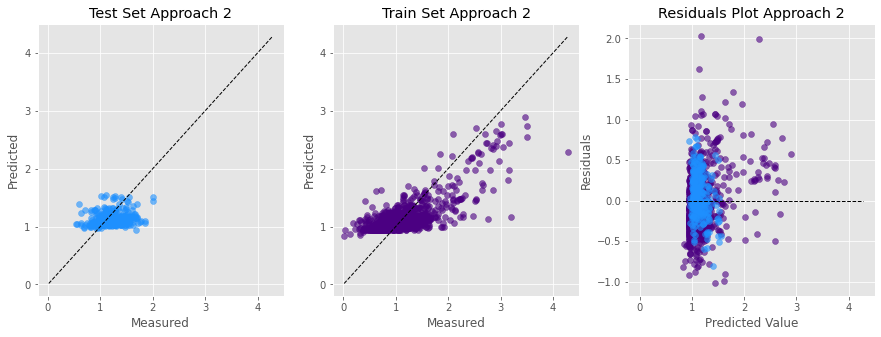

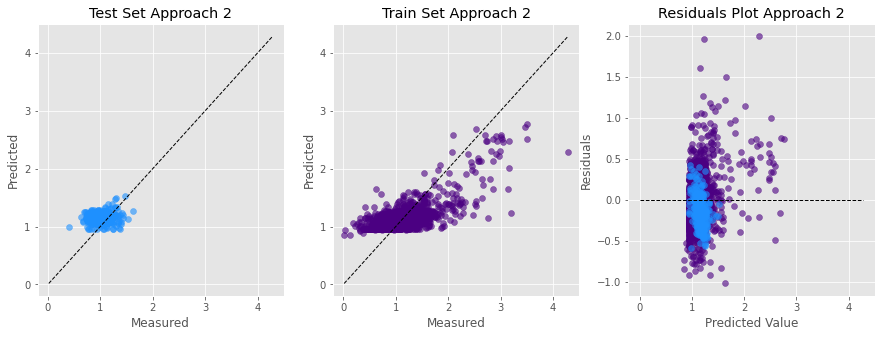

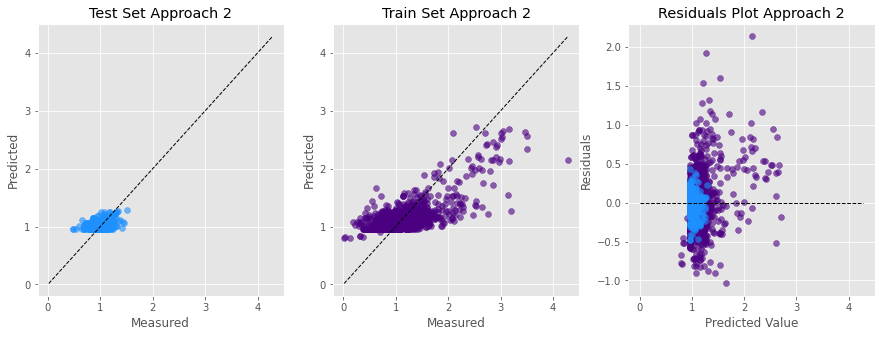

In [1238]:
y=df_time[df_time.columns[-1]]

scaler = preprocessing.StandardScaler().fit(df_time[df_time.columns[3:-1]])

X = pd.DataFrame(scaler.transform(df_time[df_time.columns[3:-1]]), columns=df_time.columns[3:-1])

tscv = TimeSeriesSplit(n_splits=6)
aux_df=pd.DataFrame(columns=['mae', 'rmse', 'mse', 'mape'])
iter = 0
for train_index, test_index in tscv.split(X): 
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]    
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    

    model = GradientBoostingRegressor(max_depth=2, n_estimators=30)
    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)
    y_pred_train=model.predict(X_train)
    
    fig, ax = plt.subplots(1,3,figsize=(15,5))
    plot_aux_2(1,y_test, y_pred, y_train, y_pred_train, ax)
    
    mae = mean_squared_error(y_pred, y_test)
    rmse = np.sqrt(mean_squared_error(y_pred, y_test))
    mse = r2_score(y_pred, y_test)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    aux_df.loc['Fold ' + str(iter)]=[mae, rmse, mse, mape]
    iter = iter+1

In [1235]:
print('Average Test Mape: ' + str(aux_df['mape'].mean()))
print('Average Test Mae: ' + str(aux_df['mae'].mean()))
cm = sns.light_palette("green", as_cmap=True)
s = aux_df.style.background_gradient(cmap=cm, subset=['std_test', 'std_train'])
s

Average Test Mape: 30.658937863717124
Average Test Mae: 0.12000983103832868


KeyError: "None of [Index(['std_test', 'std_train'], dtype='object')] are in the [columns]"

### Histogram Gradient Boosting

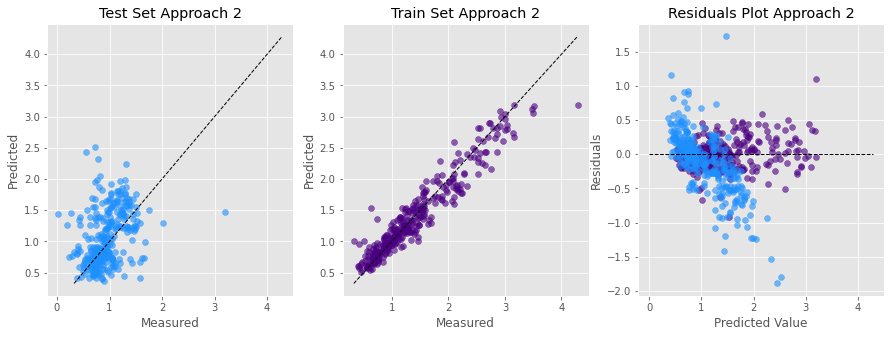

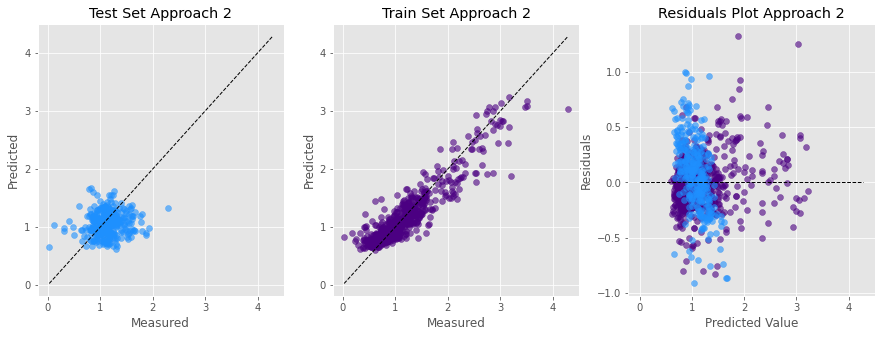

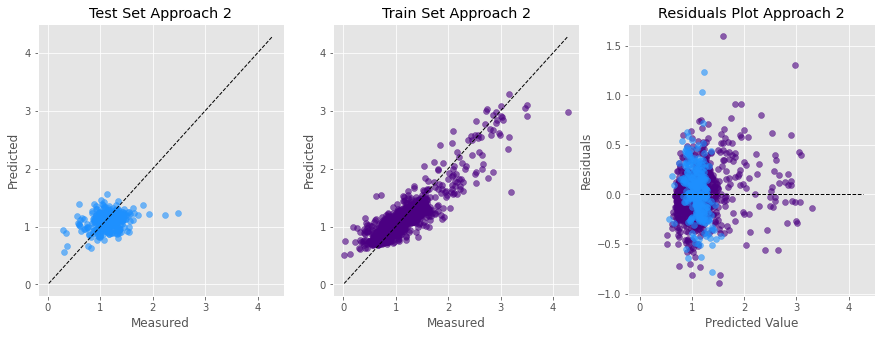

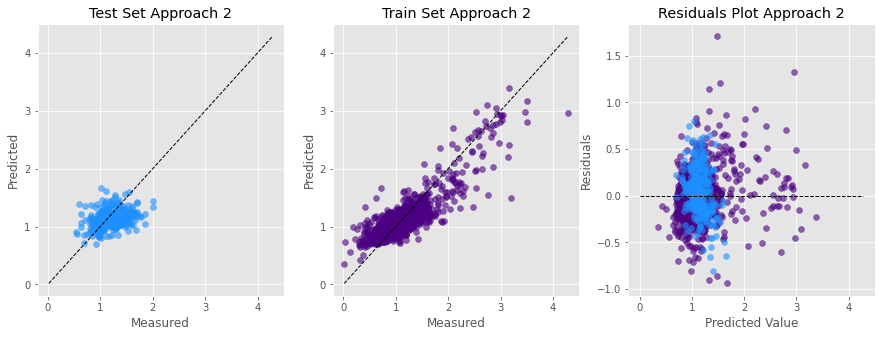

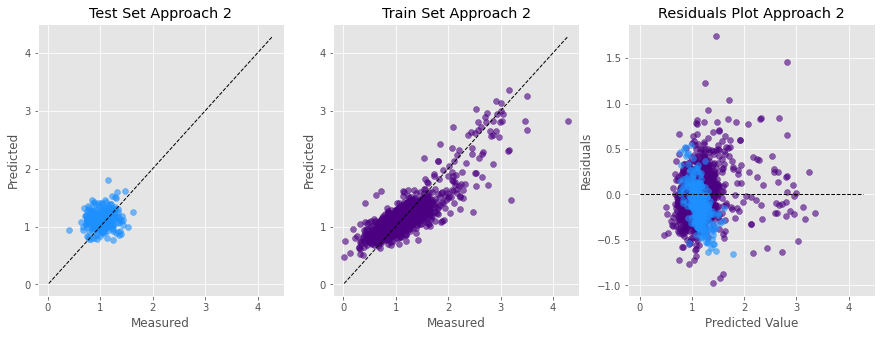

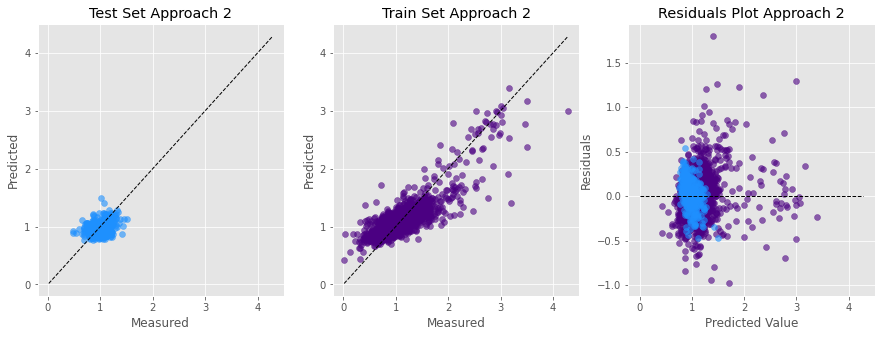

In [1241]:
y=df_time[df_time.columns[-1]]

scaler = preprocessing.StandardScaler().fit(df_time[df_time.columns[3:-1]])

X = pd.DataFrame(scaler.transform(df_time[df_time.columns[3:-1]]), columns=df_time.columns[3:-1])

tscv = TimeSeriesSplit(n_splits=6)
aux_df=pd.DataFrame(columns=['mae', 'rmse', 'mse', 'mape', 'r2_test', 'r2_train', 'std_test', 'std_train'])
iter = 0
for train_index, test_index in tscv.split(X): 
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]    
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    
    model = HistGradientBoostingRegressor(max_depth=3)
    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)
    y_pred_train=model.predict(X_train)
    
    fig, ax = plt.subplots(1,3,figsize=(15,5))
    plot_aux_2(1,y_test, y_pred, y_train, y_pred_train, ax)
    
    mae = mean_absolute_error(y_pred, y_test)
    rmse = np.sqrt(mean_squared_error(y_pred, y_test))
    mse = mean_squared_error(y_pred, y_test)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    r2_train = r2_score(y_pred_train, y_train)
    r2_test = r2_score(y_pred, y_test)
    std_train = np.var(y_train)
    std_test = np.var(y_test)
    aux_df.loc['Fold ' + str(iter)]=[mae, rmse, mse, mape, r2_test, r2_train, std_test, std_train]
    iter = iter+1

In [1166]:
print('Average Test Mape: ' + str(aux_df['mape'].mean()))
print('Average Test Mae: ' + str(aux_df['mae'].mean()))
cm = sns.light_palette("green", as_cmap=True)
s = aux_df.style.background_gradient(cmap=cm, subset=['std_test', 'std_train'])
s

Average Test Mape: 27.124123253141747
Average Test Mae: 0.21805717223755924


,mae,rmse,mse,mape,r2_test,r2_train,std_test,std_train
Fold 0,0.349695,0.483088,0.233374,59.579691,-0.098171,0.933450,0.106006,0.516943
Fold 1,0.242688,0.311090,0.096777,33.986442,-1.391799,0.870040,0.076946,0.369385
Fold 2,0.196236,0.256945,0.066020,18.921486,-1.565305,0.794752,0.065329,0.272832
Fold 3,0.207061,0.270395,0.073113,17.546534,-2.186676,0.733132,0.067582,0.221446
Fold 4,0.178177,0.222447,0.049483,18.663583,-1.091508,0.700449,0.030007,0.190989
Fold 5,0.134487,0.170087,0.028930,14.047003,-0.864676,0.646958,0.028688,0.167001


In [435]:
import pickle
model = GradientBoostingRegressor(max_depth=4)
model.fit(X_train_appch2_clean, y_train_appch2)
pickle.dump(model, open('model_hist_reg', 'wb'))
pickle.dump(scaler_appch2, open('scaler', 'wb'))

In [429]:
!pwd

/Users/lucas_botella/Downloads


In [471]:
X_train_appch2.infections_value.min()

-95.59

In [444]:
X_train_appch2.columns

Index(['mobility_index', 'residential', 'awareness_measures',
       'health_measures', 'mobility_measures', 'economic_measures',
       'closure_measures', 'holiday', 'temp', 'prcp', 'number_of_arrivals',
       'urban_population', 'total_vaccinations_per_100', 'youth_unemployment',
       'infections_value', 'accumulated'],
      dtype='object')

In [460]:
df[df['holiday']==7]

,Code,Date,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces,debt_relief,income_support,...,holiday,temp,prcp,number_of_arrivals,urban_population,total_vaccinations_per_100,youth_unemployment,infections_value,accumulated,reproduction_rate
1582,ISR,2020-04-26,-83.428714,-25.775571,29.816286,-63.918286,-64.163143,-68.244857,2.0,2.0,...,7.0,16.463542,0.04375,2900000.0,92.336,0.0,6.68,5.61,0.004132,0.908571
